# Coursework 1: Chest X-ray (100 marks)

In this coursework, you will be working with the Kaggle [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) dataset. You will analyze the dataset, and train deep learning models to classify whether an x-ray exhibits pneumonia.


Here are some additional tips:
- We recommend using weights and biases to log your training runs. This will allow you to easily compare previous runs if needed.
- Ensure your results are reproducable - we may rerun your notebook to check for this. Points will be lost if results are not reproducable.
- We recommend factorizing your code in places where you will be repeatedly using the same functionaility. For example, if you are training multiple models, consider using a common training loop function.
- Your code and results and discussions should be concise, well-presented, and easy to read. Each question has a certain portion of marks going towards this.
- Ensure you correctly use the train, validation, and test set throughout. You should only ever use the test set once - for the final evaluation.
- Consider saving your models so you can reload previous models for the final evaluation
- Ensure it is clear to the reader what any plots / figures are presenting. I.e., label axes, include titles, ensure it is clear what experiment it is from (what model / design choices, etc.)
- Google Collab restricts the amount of GPU time available. Consider debugging code, using a subset of data, on CPU compute

In [ ]:
!pip install kaggle
!pip install wandb

If you get the following error when running the import cell below this description:


```
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
```
You will need to create a kaggle account, and navigate to https://www.kaggle.com/me/account. Navigate to "API" and create a new token. This will automatically download a json file called "kaggle.json".

Run the following code, replacing the "INSERT JSON HERE TEXT" with the contents of the json that you downloaded.

```
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = INSERT JSON HERE TEXT

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json
```

INSERT JSON HERE TEXT should be something of the form:
```
{"username":"XXX","key":"XXX"}
```

In [ ]:
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = {"username":"sachinnaidoo","key":"675b6628cadfe86605ac781447118a83"}

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json

In [ ]:
import os
import random
import shutil
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load and Re-split the Raw Data

The original data is poorly split, so we will resplit it here. Do NOT edit this code.

In [ ]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1  # This is implicitly defined as 1 - (TRAIN_SPLIT + VAL_SPLIT)

In [ ]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
dataset = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
download_path = "chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {dataset} to {download_path}")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Download complete!


In [ ]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "chest_xray_dataset_new_split"

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Data re-split complete. New dataset location: chest_xray_dataset_new_split


# Question 1: Data Analysis (5 marks)

Perform some basic analysis of the statistics of the dataset.

Try to spot anything that may impact how you will design your deep learning classifier and training.

We'd expect to see:
* Analysis of labels (target variable);
* Analysis of input features;

If you do spot anything, briefly explain **how you think it may impact training**.


In [ ]:
# Collect dataset statistics
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        stats[split][cls] = len(os.listdir(path))



In [ ]:
#Set seeds to ensure reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True


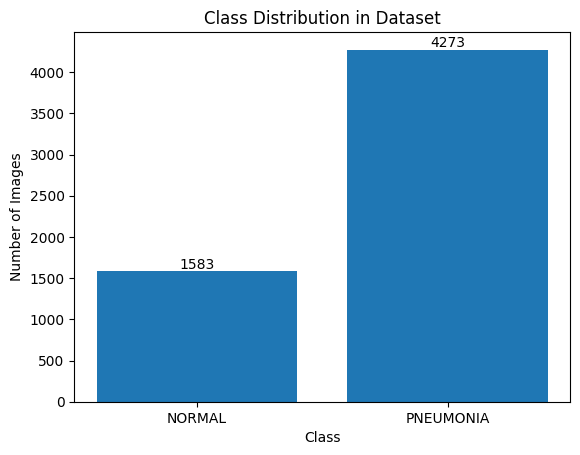

{'train': {'NORMAL': 1266, 'PNEUMONIA': 3418}, 'val': {'NORMAL': 158, 'PNEUMONIA': 427}, 'test': {'NORMAL': 159, 'PNEUMONIA': 428}}


In [ ]:
# Code below plots distribution of images (Normal and Pneumonia) in bar graph
class_size = {cls: 0 for cls in classes} #initialize dict to count number in each class where 0 is initial size
for split in splits:
  for cls in classes:
    class_size[cls] += stats[split][cls] # count the number in each class
plt.bar(class_size.keys(), class_size.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')
for x, y in enumerate(class_size.values()):
    plt.text(x, y, str(y), ha='center', va='bottom')
plt.show()
print(stats) #shows splits in each of the train, val and test set



Normal Images:
Image shape at chest_xray_dataset_new_split/train/NORMAL/IM-0525-0001-0002.jpeg: (1410, 970)


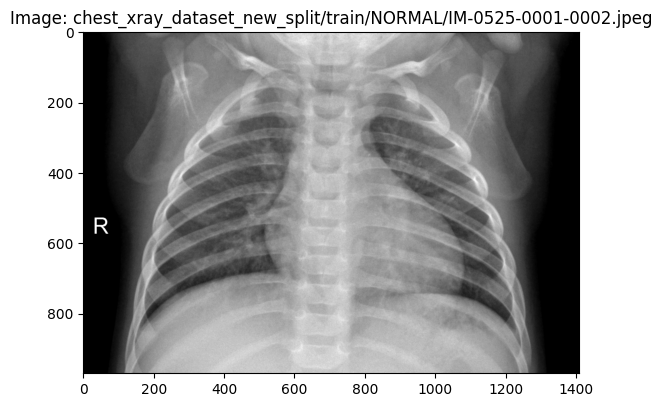

Image shape at chest_xray_dataset_new_split/train/NORMAL/IM-0011-0001.jpeg: (1863, 1785)


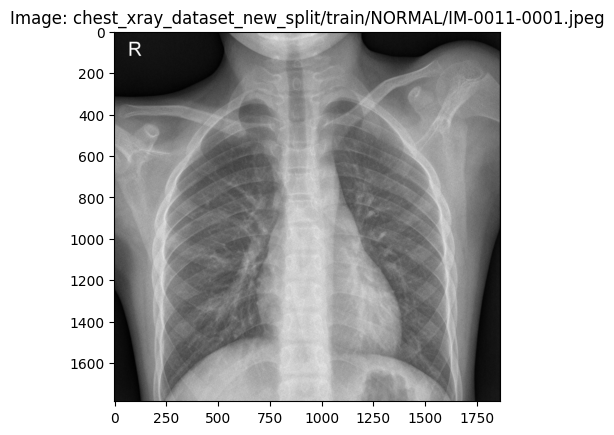

Image shape at chest_xray_dataset_new_split/train/NORMAL/IM-0430-0001.jpeg: (1438, 1082)


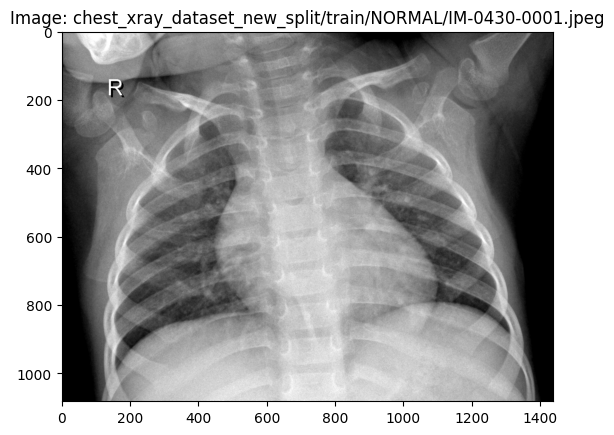





Pneumonia Images:
Image shape at chest_xray_dataset_new_split/train/PNEUMONIA/person1203_bacteria_3154.jpeg: (1040, 720)


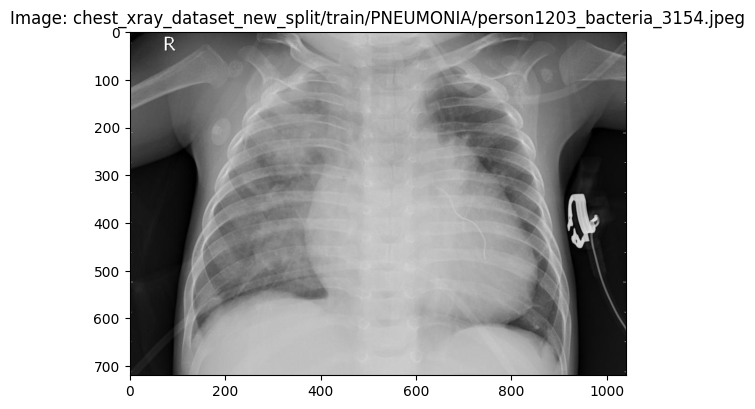

Image shape at chest_xray_dataset_new_split/train/PNEUMONIA/person328_bacteria_1515.jpeg: (1289, 1253)


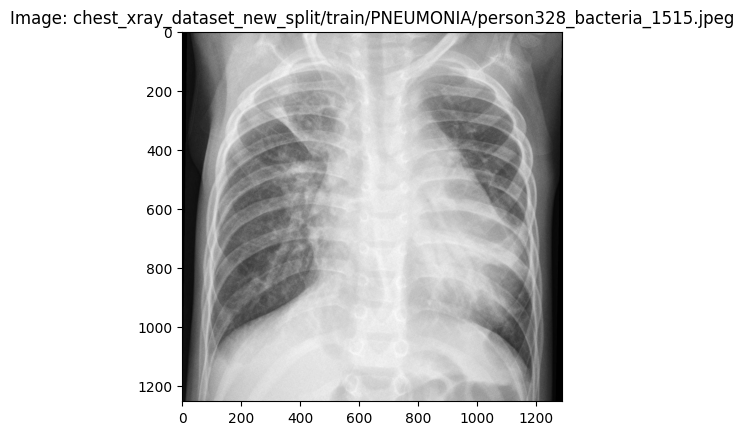

Image shape at chest_xray_dataset_new_split/train/PNEUMONIA/person310_bacteria_1450.jpeg: (1264, 896)


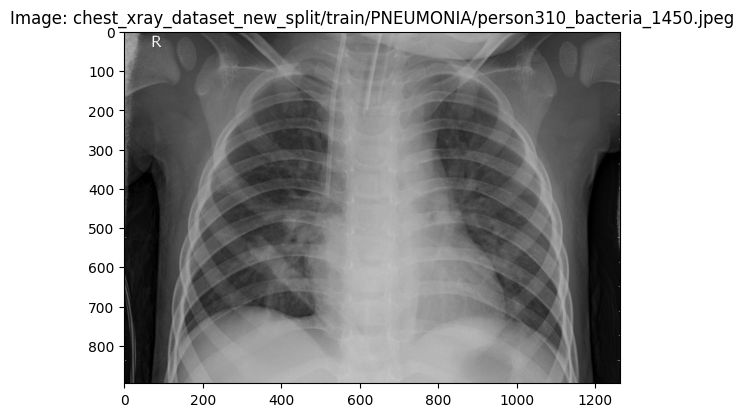

In [ ]:
########################################################################
#                              YOUR CODE HERE                          #
########################################################################

#analysis of input features
#Objective: print a few examples of images from Normal and Pneumonia set just to have a look
# Print the shape of the image as well

#function below opens an image from path and plots it. It also shows the size of the image
def analyze_image(image_path):
  img = Image.open(image_path)
  image_shape = img.size
  print(f"Image shape at {image_path}: {image_shape}") #bit messy output but just print the path of the image with the shape
  plt.imshow(img, cmap ='gray')
  plt.title(f"Image: {image_path}") #Show the image name as title
  plt.show()




#Code below stores path to files
normal_folder = os.path.join(new_dataset_path, 'train', 'NORMAL')
pneumonia_folder = os.path.join(new_dataset_path, 'train', 'PNEUMONIA')
normal_files = os.listdir(normal_folder)
pneumonia_files = os.listdir(pneumonia_folder)

#get 3 rnadom images from training dataset
num_images = 3
random_normal_images = random.sample(normal_files, num_images)
random_pneumonia_images = random.sample(pneumonia_files, num_images)

print("Normal Images:")
for image in random_normal_images:
    analyze_image(os.path.join(normal_folder, image))

print("\n\n\n")

print("Pneumonia Images:")
for image in random_pneumonia_images:
    analyze_image(os.path.join(pneumonia_folder, image))


#Result from output: the images have different sizes, so need to resize



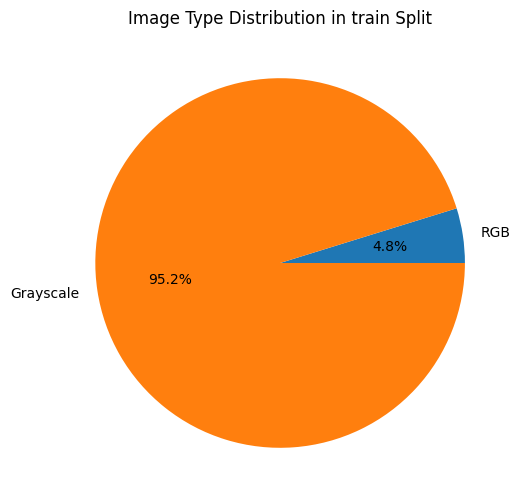

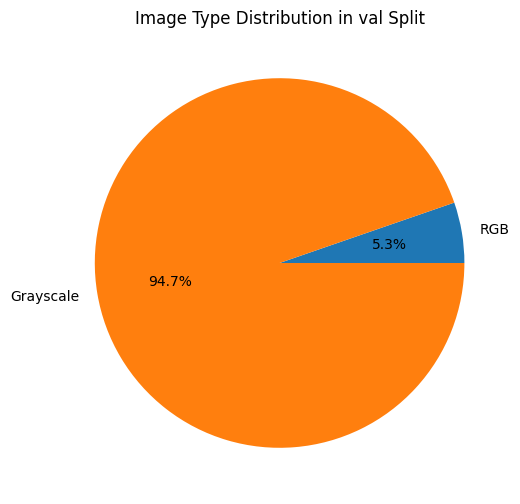

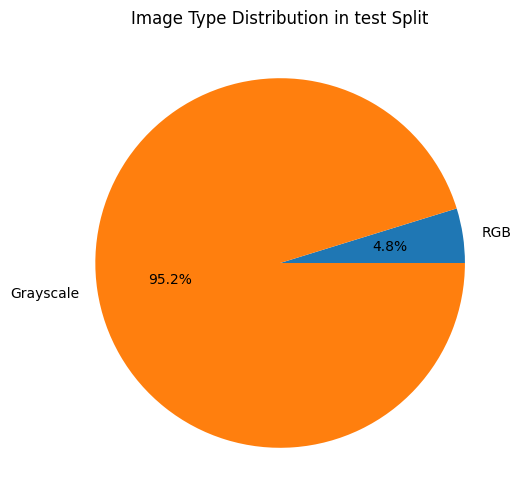

In [ ]:
#The code below is used to determine the mix of Grayscale images vs RGB

# Create a function to count the number of each image in each path
#The function below takes in a path as an input and then returns the count of grayscale and RGB images in that path
def count_image_type(path):

    grayscale_count = 0
    rgb_count = 0

    for root, _, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            image = Image.open(file_path)
            if image.mode == 'L':  # 'L' represents Grayscale
                grayscale_count += 1
            elif image.mode == 'RGB':
                rgb_count += 1

    return grayscale_count, rgb_count


# obtain counts for each class and plot their split
for split in ['train', 'val', 'test']:
    split_path = os.path.join(new_dataset_path, split)
    grayscale_count, rgb_count = count_image_type(split_path)

    #store coutns in a dictionary to make plotting easier
    image_counts = {'RGB': rgb_count, 'Grayscale': grayscale_count}

    # Create pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(image_counts.values(), labels=image_counts.keys(), autopct="%1.1f%%")
    plt.title(f"Image Type Distribution in {split} Split")
    plt.show()

**(a)**

From the Histogram showing class distribution in the dataset, there are much more Pneumonia images than Normal images. This occurs in each of the training, validation and test set. This is problematic because the model may become biased and learn predominantly from the Pneumonia class. It could also cause overfitting on the Normal class. When testing, it could also cause misleading accuracy scores e.g., the model might be good at identifying Pneumonia cases but not very good at Normal cases - but since Normal cases are much less than Pneumonia cases, the accuracy score may still be high.

How this impacts design:
I will either need to oversample from the Normal class or introduce class weightings where I assign higher weights to samples from the Normal class.

Furthermore, there aren't too many images in total in this dataset (less than 6000). I would imagine that for this complex task (identifying whether a lung X-ray has Pneumonia or not), we would need more samples. I have considered using data augmentation to articially create more samples, however this was not done in this exercise, due to computational costs.

I plotted 3 X-ray images from each class as I thought it would be nice to visually represent the classes. From this, I realized horizontal flips do not seem appropriate given that these are medical images. I am also reluctant to zoom as it may result in part of the lung not showing in the image. I had planned to implement Random Rotations (of 10 degrees) in the data transformation, however this inexplicably caused my training times to increase so I removed this. This did not greatly impact the performance of the model.
Furthermore, the title of each image contains the image size. Each X-ray has a different image size, so I need to resize it before training. Some images seem to be quite large in size - bigger than (1000,1000). When resizing, there will be a trade-off between loss of information and computational efficiency (larger resize will lose less information but take longer to run).

Some of the X-rays seem more blurry than others. This could adversely impact model performance. There may be ways of sharpening blurry images (this was not done at in this exercise).

I then plotted the proportion of grayscale images vs RGB images in each class. Most images are grayscale, however a few are RGB. I will convert all images to grayscale. This will result in easier processing (since there is 1 channel and not 3 channels).

# Question 2: Data Preparation (5 marks)

Here, you should load the dataset into torch dataloaders, performing any preprocessing required in the process.

Within the ChestXrayDataset class, the root_dir parameter is a string defining the directory containing the "train", "val" and "test" folders.

In [ ]:
dataset_path = "chest_xray_dataset_new_split"
batch_size = 32

In [ ]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        super().__init__()
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        split_dir = os.path.join(root_dir, split)

        self.images = []
        self.labels = []
        for class_dir in os.listdir(split_dir):
          class_path = os.path.join(split_dir, class_dir)
          if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
              image_path = os.path.join(class_path, image_file)
              self.images.append(image_path)
              self.labels.append(int(class_dir == 'PNEUMONIA'))  #will make it easier to calculate accuracies
              # Line above converts labels - 0 for Normal, 1 for Pneumonia



        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        image_path = self.images[idx]
        image = Image.open(image_path)
        label = self.labels[idx]

        if self.transform:
          image = self.transform(image)

        return image, label




        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [ ]:
# Define data transforms
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

#need to first calculate the mean and variance
#temp transform to make the mean and variance calculation easier
temp_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    #transforms.RandomRotation(degrees=10), #my model takes long when I include this line for some reason, so commented it out
    transforms.Resize((224,224)),
    transforms.ToTensor()
        ])

train_dataset = ChestXrayDataset(new_dataset_path, split='train', transform=temp_transform)
temp_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = False, num_workers = 6)

# Calculate mean and standard deviation
mean = torch.zeros(1)
std = torch.zeros(1)
for _, (images, _) in enumerate(temp_loader):
    mean += images.mean()
    std += images.std()
mean /= len(temp_loader)
std /= len(temp_loader)

data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    #transforms.RandomRotation(degrees=10),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)  # Normalize data
        ])


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# The block below uses WeightedRandomSampler
# We need to add more weight to Normal images since there are much fewer than Pneumonia images

class_count = torch.tensor([0, 0])  # Initialize with zeros
for _, label in train_dataset:
    class_count[label] += 1 #since label is either 0 or 1

weights = [1. / count for count in class_count] #calculate weights for each class
print(weights)
assigned_weights = [] #create list to assign weights to each observation in the training set
for _, label in train_dataset:
    if label == 0:
        assigned_weights.append(weights[0])
    elif label == 1:
        assigned_weights.append(weights[1])

print(weights)
sampler = WeightedRandomSampler(assigned_weights, len(train_dataset))

[tensor(0.0008), tensor(0.0003)]


In [ ]:
# just a sense quick check. Output makes sense.
# larger weights applied to Normal images (0)
print(sampler.weights)
print(train_dataset.labels)

tensor([0.0003, 0.0003, 0.0003,  ..., 0.0008, 0.0008, 0.0008],
       dtype=torch.float64)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
# Create datasets
# Define training, validation, and test datasets
train_dataset = ChestXrayDataset(new_dataset_path, split='train', transform=data_transform)
val_dataset = ChestXrayDataset(new_dataset_path, split='val', transform=data_transform)
test_dataset = ChestXrayDataset(new_dataset_path, split='test', transform=data_transform)
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler = sampler ,num_workers = 6)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,  num_workers = 6)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers = 6)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset.images)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


# Print batch shapes
for images, labels in train_loader:
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)
    break






Training dataset size: 4684
Validation dataset size: 585
Test dataset size: 587


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Image shape: torch.Size([32, 1, 224, 224])
Label shape: torch.Size([32])


**(a)**

_Insert brief discussion of any design choices you made here_

BATCH SIZE

I chose 32 as a batch size simply because it's a common batch size. I had considered using 16 instead, as it allows the model to update parameters more frequently in training - however it resulted in a longer training time. Batch size of 32 was the next best option as it gives the model a higher chance of finding a global minimum during training, as parameters are updated more frequently in each epoch


LABEL

In the ChestXrayDataset, I coded the labels such that Normal images have a label of 0 and Pneumonia images have a label of 1. This wasn't fully necessary but will just make it easier to calculate accuracy later.


DATA TRANSFORMS

I converted the images to grayscale in order to reduce the computational burden. There is only 1 input channel instead of 3 in RGB. This should allow the model to train faster. Furthermore, most images in the original dataset were Grayscale already. In general, grayscale might also reduce noise and allow the model to focus on more important patterns than colour images.

I did not believe that certain augmentations such as vertical/horizontal flips were appropriate as the lung is an organ and the correct orientation and shape may be important for accurate diagnosis. X-Ray images are also largely quite standard. Certain transformation might adversely impact the medical integrity of the image.
However, when plotting Random images (in part 1), I noticed that the position of the patients' lungs were positioned slightly differently in each X-Ray, so I planned to implement a small random rotation of 10 degrees maximum. This would help the model generalize and reduce overfitting. However, for some inexplicable reason, the random rotation caused the model runtime to be quite long (especially when looping through the train_loader), so I removed the random rotation. This did not greatly impact overall model performance.

I resized to (224,224). This makes the X-ray images smaller than their original size (by 4-fold or 5-fold in some cases). There is a trade-off between computational efficiency and loss of information. I believed 224 struck a good balance between retaining information and still keeping a reasonable runtime.

Lastly, I normalized the pixels in the dataset. This should help improve model performance.


SAMPLER

From part 1, we saw there was a class imbalance - with far more Pneumonia images than Normal images. WeightedRandomSampler is a tool to help manage class imabalnce. Pneumonia images were about 8/3 times were prevalent than Normal images; therefore higher weights were applied to images from the Normal class. This should help address the class imbalance during training

# Question 3: Training a Baseline (30 marks)

You will now establish an initial baseline model and training procedure. This should be as simple as possible, without using any elaborate design choices, whilst still obtaining reasonable performance (i.e., at least better than random chance). You will attempt to improve upon this baseline in later questions.

When answering this question, consider what makes a good baseline:
* Easily converges;
* Easy to implement;
* Established architectural components that have proved well suited to the data-type and problem.
* Obtains reasonable performance e.g, better than random guess

You will be required to explain your design choices, and to present and discuss you results.

The code below is a suggested structure to guide you. You are free to deviate from this __however, it must be obvious to the marker__:
* What the final proposed baseline model is (in terms of architecture);
* What the performance of the baseline model is and how the model has been trained;
* What your written justification and discussion is;



In [ ]:
num_epochs = 10
use_wandb = False  # Set to True if you want to use wandb
lr = 0.001

In [ ]:
# Define the model
class SimpleModel(nn.Module):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
          self.relu = nn.ReLU()
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

          self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
          self.relu2 = nn.ReLU()
          self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

          self.flatten = nn.Flatten()

          self.fc = nn.Linear(16 * 56 * 56, 2)

        def forward(self, x):
          x = self.conv1(x)
          x = self.relu(x)
          x = self.pool(x)
          x = self.conv2(x)
          x = self.relu2(x)
          x = self.pool2(x)
          x = self.flatten(x)

          x = self.fc(x)
          x = torch.softmax(x, dim=1) #so outputs can be interpreted as probabilities


          return x



        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


In [ ]:
#NOTE TO MARKER: THE FUNCTION calculate_accuracy DIRECTLY BELOW WASN'T IN THE TEMPLATE
# function takes in a list of model outputs and actual data labels to overall calculate accuracy per batch
def calculate_accuracy(outputs, labels):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        max_val, pred = torch.max(outputs.data, dim =1) #pred stores the index with the highest probability
        correct = (pred == labels).sum().item() #counts number of correct predictions
        total = labels.size(0) #total predictions made
        accuracy = correct / total

        return accuracy


def calculate_class_accuracies(outputs, labels):

    max_val, pred = torch.max(outputs, 1)

    # Calculate class-wise accuracies
    class_0_correct = (pred == 0) & (labels == 0)  # total correct for Normal class (0)
    class_1_correct = (pred == 1) & (labels == 1)  # total correct for Pneumonia class (1)
    class_0_total = torch.sum(labels == 0).item()  # total images processed in Normal class
    class_1_total = torch.sum(labels == 1).item()  # total images processed in Pneumonia class

    return class_0_correct, class_1_correct, class_0_total, class_1_total
    #some batches might have 4 NORMAL, some might have 8 NORMAL, easier to return totals and do accuracy calc later

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda', use_wandb=False):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

        # initialie arrays to keep track of values
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        train_class_accuracies = []  #didn't use this, but just kept it as it was included in the template
        val_class_accuracies = [] #didn't use this, but just kept it as it was included in the template
        #the below lists keep track of the accuracies per class
        train_class_0_accuracies = []
        train_class_1_accuracies = []
        val_class_0_accuracies = []
        val_class_1_accuracies = []


        for epoch in range(num_epochs):
          if use_wandb:
            wandb.login()
            config={
              "train_loss": 0,
              "train_accuracy": 0,
              "val_loss": 0,
              "val_accuracy": 0,
              "epoch": 0
                }
            wandb.init(project='COMP0188_CW1_Questions', config=config)
          model.train()
          #initialize variables
          train_epoch_loss = 0.0
          train_epoch_accuracy = 0.0
          train_epoch_class_accuracy = 0.0
          train_epoch_class_0_correct = 0.0
          train_epoch_class_1_correct = 0.0
          train_epoch_class_0_total = 0.0
          train_epoch_class_1_total = 0.0

          for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #keep track of losses per batch
            train_epoch_loss += loss.item()

            #the below sums accuracy per batch
            train_epoch_accuracy += calculate_accuracy(outputs, labels)

            #store number correct and the total of each class processed per batch
            class_0_correct, class_1_correct, class_0_total, class_1_total = calculate_class_accuracies(outputs, labels)
            #keeps track of total correct per epoch per batch
            train_epoch_class_0_correct+= class_0_correct.sum().item()
            train_epoch_class_1_correct += class_1_correct.sum().item()
            #keeps track of total per epoch per batch - in hindsight, not necessary but still perfectly accurate
            train_epoch_class_0_total += class_0_total
            train_epoch_class_1_total += class_1_total


          train_epoch_loss /= len(train_loader) #average loss on all batches in the epoch
          train_epoch_accuracy /= len(train_loader) #gets average accuracy across the batches


          #Validation
          # similar method to training
          model.eval()
          val_epoch_loss = 0.0
          val_epoch_accuracy = 0.0
          val_epoch_class_accuracy = 0.0
          val_epoch_class_0_accuracy = 0.0
          val_epoch_class_1_accuracy = 0.0
          val_epoch_class_0_correct = 0.0
          val_epoch_class_1_correct = 0.0
          val_epoch_class_0_total = 0.0
          val_epoch_class_1_total = 0.0

          with torch.no_grad():
            for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels)
              val_epoch_loss += loss.item()
              val_epoch_accuracy += calculate_accuracy(outputs, labels)

              class_0_correct, class_1_correct, class_0_total, class_1_total = calculate_class_accuracies(outputs, labels)
              val_epoch_class_0_correct+= class_0_correct.sum().item()
              val_epoch_class_1_correct += class_1_correct.sum().item()
              val_epoch_class_0_total += class_0_total
              val_epoch_class_1_total += class_1_total

          val_epoch_loss /= len(val_loader)
          val_epoch_accuracy /= len(val_loader)

          #The code below stores losses and accuracies for each epoch in the appropriate list
          train_losses.append(train_epoch_loss) #train loss list
          train_accuracies.append(train_epoch_accuracy)
          val_losses.append(val_epoch_loss) #val loss list
          val_accuracies.append(val_epoch_accuracy)

          #Ignore 2 lines below - I used a different method to calculate the class accuracies
          train_class_accuracies.append(train_epoch_class_accuracy) #not necessary but this variable was in the template
          val_class_accuracies.append(val_epoch_class_accuracy) #not necessary but this variable was in the template

          #The lines below is how I calculated class accuracy. It counts the number correct divided by the total number of each class per epoch
          train_class_0_accuracies.append(train_epoch_class_0_correct / train_epoch_class_0_total)
          train_class_1_accuracies.append(train_epoch_class_1_correct / train_epoch_class_1_total)
          val_class_0_accuracies.append(val_epoch_class_0_correct / val_epoch_class_0_total)
          val_class_1_accuracies.append(val_epoch_class_1_correct / val_epoch_class_1_total)

          if use_wandb:
            wandb.log({
                "train_loss": train_epoch_loss,
                "train_accuracy": train_epoch_accuracy,
                "val_loss": val_epoch_loss,
                "val_accuracy": val_epoch_accuracy,
                "epoch": epoch
            })
            wandb.finish()

          print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.4f}")

        #NOTE TO MARKER: I ADDED train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies to store class accuracies instead
        return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################




In [ ]:
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies,train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

        #Want to plot losses, overall accuracies, train class accuracies and val class accuracies

        fig, axes = plt.subplots(2,2, figsize=(12,4))

        ax1 = axes[0, 0]
        ax2 = axes[0, 1]
        ax3 = axes[1, 0]
        ax4 = axes[1, 1]

        ax1.plot(train_losses, label=f"train_losses")
        ax1.plot(val_losses, label=f"val_losses")

        ax1.set_title('Losses per epoch')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()

        ax2.plot(train_accuracies, label=f"train_accuracies")
        ax2.plot(val_accuracies, label=f"val_accuracies")
        ax2.set_title('Accuracy plot')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        ax3.plot(train_class_0_accuracies, label=f"Normal")
        ax3.plot(train_class_1_accuracies, label=f"Pneumonia")
        ax3.set_title('Train Class Accuracies')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Class Accuracy')
        ax3.legend()

        ax4.plot(val_class_0_accuracies, label=f"Normal")
        ax4.plot(val_class_1_accuracies, label=f"Pneumonia")
        ax4.set_title('Val Class Accuracies')
        ax4.set_xlabel('Epochs')
        ax4.set_ylabel('Class Accuracy')
        ax4.legend()

        plt.tight_layout()
        plt.show()


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [ ]:
# Initialize the model


model = SimpleModel().to(device)
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= lr)

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Train the model
if use_wandb:
  wandb.login()

#had to include more variables below to store additional lists on class accuracies
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)
if use_wandb:
  wandb.finish()


Epoch 1/10: Train Loss: 0.5770, Train Acc: 0.8068, Val Loss: 0.5364, Val Acc: 0.8438
Epoch 2/10: Train Loss: 0.4836, Train Acc: 0.8881, Val Loss: 0.4488, Val Acc: 0.9112
Epoch 3/10: Train Loss: 0.4514, Train Acc: 0.8977, Val Loss: 0.4347, Val Acc: 0.9211
Epoch 4/10: Train Loss: 0.4305, Train Acc: 0.9140, Val Loss: 0.4472, Val Acc: 0.8832
Epoch 5/10: Train Loss: 0.4108, Train Acc: 0.9245, Val Loss: 0.3921, Val Acc: 0.9605
Epoch 6/10: Train Loss: 0.4028, Train Acc: 0.9301, Val Loss: 0.3862, Val Acc: 0.9589
Epoch 7/10: Train Loss: 0.3994, Train Acc: 0.9293, Val Loss: 0.3869, Val Acc: 0.9474
Epoch 8/10: Train Loss: 0.3997, Train Acc: 0.9256, Val Loss: 0.3852, Val Acc: 0.9424
Epoch 9/10: Train Loss: 0.3899, Train Acc: 0.9352, Val Loss: 0.3917, Val Acc: 0.9309
Epoch 10/10: Train Loss: 0.3895, Train Acc: 0.9350, Val Loss: 0.3825, Val Acc: 0.9375


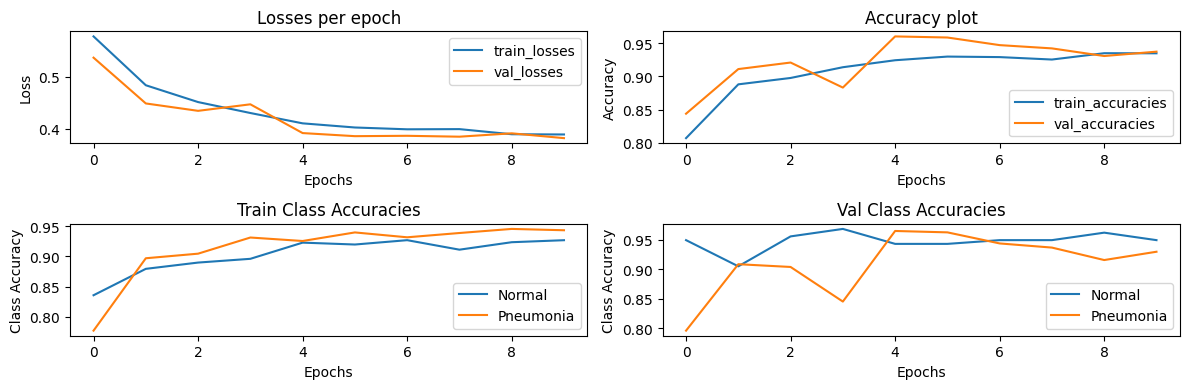

In [ ]:
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies,train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies)


In [ ]:

torch.save(model.state_dict(), 'chest_xray_model.pth')

#Messy output but prints numerical results for me to analyze
print("Model saved as 'chest_xray_model.pth'")
print("Train losses: ", train_losses)

print("Train accuracies: ", train_accuracies)
print("Train class accuracies: ", train_class_accuracies)
print("Val losses: ", val_losses)
print("Val accuracies: ", val_accuracies)
print("Val class accuracies: ", val_class_accuracies)
print("Train class Normal accuracies: ", train_class_0_accuracies)
print("Train class Pneumonia accuracies: ", train_class_1_accuracies)
print("Val class Normal accuracies: ", val_class_0_accuracies)
print("Val class Pneumonia accuracies: ", val_class_1_accuracies)



Model saved as 'chest_xray_model.pth'
Train losses:  [0.5770421514705736, 0.4836307841093362, 0.4514434047702218, 0.4305232400391378, 0.4107569178350929, 0.4028266562896521, 0.3993605580054173, 0.39971132018939165, 0.3899112759398765, 0.38946145347186495]
Train accuracies:  [0.8068310657596373, 0.888109410430839, 0.8977465986394558, 0.9139739229024942, 0.92453231292517, 0.9300595238095238, 0.9292800453514739, 0.9255952380952381, 0.9351615646258503, 0.9350198412698412]
Train class accuracies:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Val losses:  [0.5364009534057818, 0.4488165802077243, 0.4346764777836047, 0.4471682278733504, 0.39213438567362335, 0.38622936292698506, 0.3869284030638243, 0.3852238576663168, 0.3916587625679217, 0.382459852256273]
Val accuracies:  [0.84375, 0.9111842105263158, 0.9210526315789473, 0.8832236842105263, 0.9605263157894737, 0.9588815789473685, 0.9473684210526315, 0.9424342105263158, 0.930921052631579, 0.9375]
Val class accuracies:  [0.0, 0.0, 0.0, 0.0

In [ ]:
#Added after - storing output in individual lists to plot later. It is simply the output above
#not ideal but doing this to prevent re-running model and wasting limited GPU space
sm_train_losses =  [0.5770421514705736, 0.4836307841093362, 0.4514434047702218, 0.4305232400391378, 0.4107569178350929, 0.4028266562896521, 0.3993605580054173, 0.39971132018939165, 0.3899112759398765, 0.38946145347186495]
sm_train_acc =  [0.8068310657596373, 0.888109410430839, 0.8977465986394558, 0.9139739229024942, 0.92453231292517, 0.9300595238095238, 0.9292800453514739, 0.9255952380952381, 0.9351615646258503, 0.9350198412698412]
sm_val_losses =  [0.5364009534057818, 0.4488165802077243, 0.4346764777836047, 0.4471682278733504, 0.39213438567362335, 0.38622936292698506, 0.3869284030638243, 0.3852238576663168, 0.3916587625679217, 0.382459852256273]
sm_val_acc =  [0.84375, 0.9111842105263158, 0.9210526315789473, 0.8832236842105263, 0.9605263157894737, 0.9588815789473685, 0.9473684210526315, 0.9424342105263158, 0.930921052631579, 0.9375]
sm_train_normal_acc = [0.8358401375161152, 0.8795180722891566, 0.8898924731182796, 0.8961038961038961, 0.922883487007544, 0.9197609901835254, 0.9269542930371636, 0.9112271540469974, 0.9235836627140975, 0.9269018274543136]
sm_train_p_acc = [0.7772592278319899, 0.8970338983050847, 0.9046206019499788, 0.9313395113732098, 0.9255874673629243, 0.9397693293464332, 0.9317114810072556, 0.9388097233864208, 0.9455754050685501, 0.9433719433719434]
sm_val_normal_acc = [0.9493670886075949, 0.9050632911392406, 0.9556962025316456, 0.9683544303797469, 0.9430379746835443, 0.9430379746835443, 0.9493670886075949, 0.9493670886075949, 0.9620253164556962, 0.9493670886075949]
sm_val_p_acc = [0.7962529274004684, 0.9086651053864169, 0.9039812646370023, 0.8454332552693209, 0.9648711943793911, 0.9625292740046838, 0.9437939110070258, 0.936768149882904, 0.9156908665105387, 0.9297423887587822]

**(a)**

_Insert brief explanation of the design choices you made_

HYPERPARAMTERS

Epochs: this was set to 10. The results (shown later) shows that the model starts to converge within 10 epochs. Ideally I would have liked to experiment with more epochs but I stuck with 10 - mainly due to computational effiency. It maintains a good balance between training time and model performance (especially because I was running out of GPU usage). 10 epochs could also help prevent overfitting.

Learning rate: I used a learning rate of 0.001 as it is a commonly used learning rate for learning tasks. It provides a good balance between model stability and fast convergence to a minimum.


SIMPLE MODEL DESIGN

I designed a simple CNN with 2 hidden layers, using ReLu activation functions and max pooling. I wanted the baseline model to be a CNN as these are known for good performance on image tasks. I believe the baseline model strikes a good balance between simplicity and providing a good objective way to measure my final model. I will explain each design choice below:

Hidden layers: 2 hidden layers was a good choice to keep it simple. I thought 1 layer would have been too simple but more than 2 would not have been appropriate for a simple model.

Output channels: there were 8 output channels in the first layer and 16 output channels in the second layer. These were selected as they are commonly used and favour efficiency and quicker model runtimes. Generally, smaller filters are also less likely to overfit than larger ones.

Kernel size: I used a kernel size of 3 as it is commonly used. Setting it to 3 may help with feature extraction.

Stride: did not want to change this as it may lead to loss of information. Larger strides reduce computaitonal costs but I already reduced computational cost by using a small number of epochs and smaller layers.

Padding: set to 1 so that output size of image is the same as the input size.

Activation Function: ReLu was chosen as the activation function as it is popular with CNNs. Like other activation functions, it introduces non-linearity.

MaxPooling: this is quite popular in image tasks. It causes dimensionality reduction, but also feature extraction - where the most important features are trained on. It also helps with more efficient training due to the dimensionality reduction.

Softmax: at the end, I used a softmax activation function so that outputs of the CNN can be interpreted as probabilities of belonging to each class.

Cross Entropy Loss: generally considered a good loss function for binary classification tasks. It measures the difference between the predicted probability and the true value



TRAINING FUNCTION

I initialized lists to keep track of losses and accuracies for training and validation - overall and per class. I deviated slightly from the template and created individual lists to keep track of accuracy per class.







**(b)**

_Present your results, including plots etc. here_

## Model Run
Epoch 1/10: Train Loss: 0.5770, Train Acc: 0.8068, Val Loss: 0.5364, Val Acc: 0.8438

Epoch 2/10: Train Loss: 0.4836, Train Acc: 0.8881, Val Loss: 0.4488, Val Acc: 0.9112

Epoch 3/10: Train Loss: 0.4514, Train Acc: 0.8977, Val Loss: 0.4347, Val Acc: 0.9211

Epoch 4/10: Train Loss: 0.4305, Train Acc: 0.9140, Val Loss: 0.4472, Val Acc: 0.8832

Epoch 5/10: Train Loss: 0.4108, Train Acc: 0.9245, Val Loss: 0.3921, Val Acc: 0.9605

Epoch 6/10: Train Loss: 0.4028, Train Acc: 0.9301, Val Loss: 0.3862, Val Acc: 0.9589

Epoch 7/10: Train Loss: 0.3994, Train Acc: 0.9293, Val Loss: 0.3869, Val Acc: 0.9474

Epoch 8/10: Train Loss: 0.3997, Train Acc: 0.9256, Val Loss: 0.3852, Val Acc: 0.9424

Epoch 9/10: Train Loss: 0.3899, Train Acc: 0.9352, Val Loss: 0.3917, Val Acc: 0.9309

Epoch 10/10: Train Loss: 0.3895, Train Acc: 0.9350, Val Loss: 0.3825, Val Acc: 0.9375


## Simple Model Results

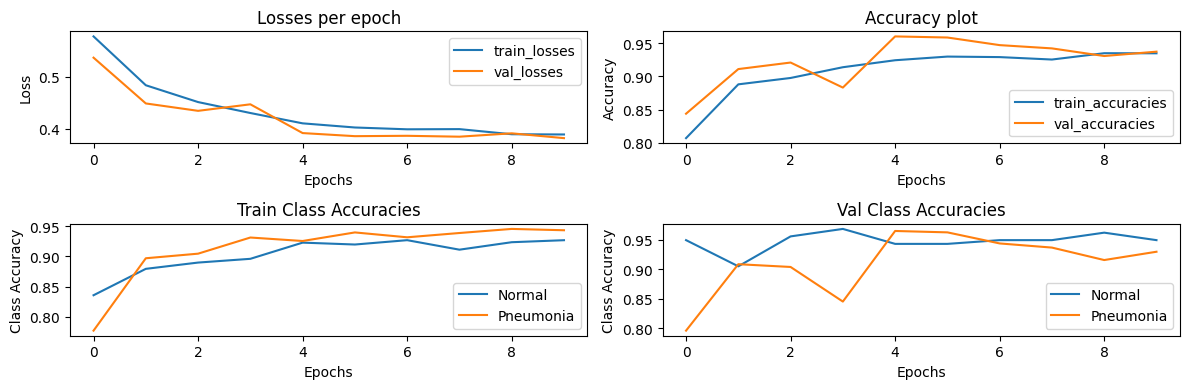


## Numerical Results

**Train losses:**  [0.5770421514705736, 0.4836307841093362, 0.4514434047702218, 0.4305232400391378, 0.4107569178350929, 0.4028266562896521, 0.3993605580054173, 0.39971132018939165, 0.3899112759398765, 0.38946145347186495]

**Train accuracies:**  [0.8068310657596373, 0.888109410430839, 0.8977465986394558, 0.9139739229024942, 0.92453231292517, 0.9300595238095238, 0.9292800453514739, 0.9255952380952381, 0.9351615646258503, 0.9350198412698412]

**Val losses:**  [0.5364009534057818, 0.4488165802077243, 0.4346764777836047, 0.4471682278733504, 0.39213438567362335, 0.38622936292698506, 0.3869284030638243, 0.3852238576663168, 0.3916587625679217, 0.382459852256273]

**Val accuracies:**  [0.84375, 0.9111842105263158, 0.9210526315789473, 0.8832236842105263, 0.9605263157894737, 0.9588815789473685, 0.9473684210526315, 0.9424342105263158, 0.930921052631579, 0.9375]

**Train class Normal accuracies:**  [0.8358401375161152, 0.8795180722891566, 0.8898924731182796, 0.8961038961038961, 0.922883487007544, 0.9197609901835254, 0.9269542930371636, 0.9112271540469974, 0.9235836627140975, 0.9269018274543136]

**Train class Pneumonia accuracies:**  [0.7772592278319899, 0.8970338983050847, 0.9046206019499788, 0.9313395113732098, 0.9255874673629243, 0.9397693293464332, 0.9317114810072556, 0.9388097233864208, 0.9455754050685501, 0.9433719433719434]

**Val class Normal accuracies:**  [0.9493670886075949, 0.9050632911392406, 0.9556962025316456, 0.9683544303797469, 0.9430379746835443, 0.9430379746835443, 0.9493670886075949, 0.9493670886075949, 0.9620253164556962, 0.9493670886075949]

**Val class Pneumonia accuracies:**  [0.7962529274004684, 0.9086651053864169, 0.9039812646370023, 0.8454332552693209, 0.9648711943793911, 0.9625292740046838, 0.9437939110070258, 0.936768149882904, 0.9156908665105387, 0.9297423887587822]

**(c)**

_Discuss your results here_

##Overall Result##

The simple model performed quite well on the training and validation set. By the 10th epoch, training accuracy was 93.5% and validation accuracy was 93.75%. There is little to suggest that overfitting occurs, although the performance metrics begin to plateau in the last few epochs of training. The results suggest that a more complex model may be able to achieve better results.

##Losses per epoch##

The graph showing **"Losses per epoch"** showed a stable decrease in training losses and a reasonably stable decrease in validation losses. This indicates that the learning rate was appropriate, and that the model was successfully adjusting parameters to fit the training data. The model learns quite sharply across the first few epochs and then begins to plateau by the final few epochs. Losses on the training set slow down by the final few epochs - however there is still a decrease indicating the model is still learning (although very little). This could indicate that the model is converging.
The plateau in losses is particularly evident on the validation set - after the first 4 epochs, there is not much improvement in validation loss and it stays around 0.38-0.39. From this graph alone, there is little evidence to suggest overfitting (as there is no increase in validation losses after it has increased). Overfitting occurs when the validation loss diverges from the training loss. This graph might indicate that the model can be made more complicated, however, the plateau of the validation loss might also indicate that making the model more complex, might cause overfitting where validation loss will diverge from training loss.


##Accuracy plot##

Results are similar to the "Losses per epoch" graph. As expected, accuracy on the first epoch is lower and increases as the model trains with each epoch. Training accuracies improve rapidly at earlier epochs, however they begin to plateau at later epochs. There is still an upward trend which may imply the model is still learning. Conversely, validation accuracies peaked at the 5th epoch (at 96%) and then decreased slightly to below 94%. This, alone, may indicate the model begins to overfit after the 5th epoch. However, the "Losses per epoch" plot does not show a corresponding increase in validation loss after the 5th epoch - so we cannot conclude that overfitting occurs.

##Train Class Accuracies and Val Class Accuracies##

There is not much difference in class accuracies between the Normal class and Pneumonia class (as expected since WeightedRandomSampler was used in data preprocessing). Interestingly, accuracy on the Pneumonia class was higher in the training set but lower on the validation set. However, overall, the plots do not suggest that the model favours one class over another.





# Question 4: Improving the Baseline (50 marks)
After analysing the results of your baseline, can you spot any clear areas for improvement, or think of any obvious improvements to your model and training setup that will improve performance?

You are free to try out as many improvements as you want here. You may also try modifying aspects of the data.

**However, for the final code and results you present in your submission, you should use exactly 3 design choices which (attempt to) improve upon the baseline.**

Tips:
* If you struggle to improve upon the baseline, but your design choices are well motivated and well implemented, and your results are well-presented and discussed, you will still receive most marks here. You will get some extra marks for improving upon baseline performance, but you will primarily be marked for making reasonable design choices.
* A small number of marks will be deducted if there are extremely obvious issues with the baseline that you do not attempt to address

## Q 4.1: Final improved model -- baseline + 3 improvements (20 marks)



You should now choose three final improvements. Explain them, implement them, train a model, and present and discuss the results.

Try to maximize performance with the final three improvements you choose (i.e., pick the three best improvements you found).

In [ ]:
# Implement the improvements and train the model in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #

#CHANGE 1
# Wider network by increasing number of filters

#CHANGE 2
# Batch Normalization

#CHANGE 3
# L2 regularization to improve generalization, using weight-decay



########################################################################

In [ ]:
class improved_Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(16)
    self.relu1 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2, 2)

    self.flatten = nn.Flatten()

    self.fc = nn.Linear(32 * 56 * 56, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.pool2(x)

    x = self.flatten(x)
    x = self.fc(x)

    x = torch.softmax(x, dim=1) #so outputs can be interpreted as probabilities

    return x

In [ ]:
#L2 Regularization

# Initialize the model
model_improved = improved_Model().to(device)

criterion_improved = nn.CrossEntropyLoss()
optimizer_improved = torch.optim.SGD(model_improved.parameters(), lr= lr, weight_decay=0.001)


train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies = train_model(
    model_improved, train_loader, val_loader, criterion_improved, optimizer_improved, num_epochs, device, use_wandb
)
# glad to see all metrics are better than Q3

Epoch 1/10: Train Loss: 0.4916, Train Acc: 0.8198, Val Loss: 0.4200, Val Acc: 0.9046
Epoch 2/10: Train Loss: 0.3780, Train Acc: 0.9371, Val Loss: 0.3529, Val Acc: 0.9638
Epoch 3/10: Train Loss: 0.3562, Train Acc: 0.9601, Val Loss: 0.3456, Val Acc: 0.9678
Epoch 4/10: Train Loss: 0.3635, Train Acc: 0.9524, Val Loss: 0.3507, Val Acc: 0.9688
Epoch 5/10: Train Loss: 0.3540, Train Acc: 0.9626, Val Loss: 0.3540, Val Acc: 0.9638
Epoch 6/10: Train Loss: 0.3545, Train Acc: 0.9617, Val Loss: 0.3688, Val Acc: 0.9474
Epoch 7/10: Train Loss: 0.3482, Train Acc: 0.9689, Val Loss: 0.3581, Val Acc: 0.9547
Epoch 8/10: Train Loss: 0.3474, Train Acc: 0.9709, Val Loss: 0.3794, Val Acc: 0.9359
Epoch 9/10: Train Loss: 0.3436, Train Acc: 0.9749, Val Loss: 0.3513, Val Acc: 0.9638
Epoch 10/10: Train Loss: 0.3423, Train Acc: 0.9751, Val Loss: 0.3501, Val Acc: 0.9655


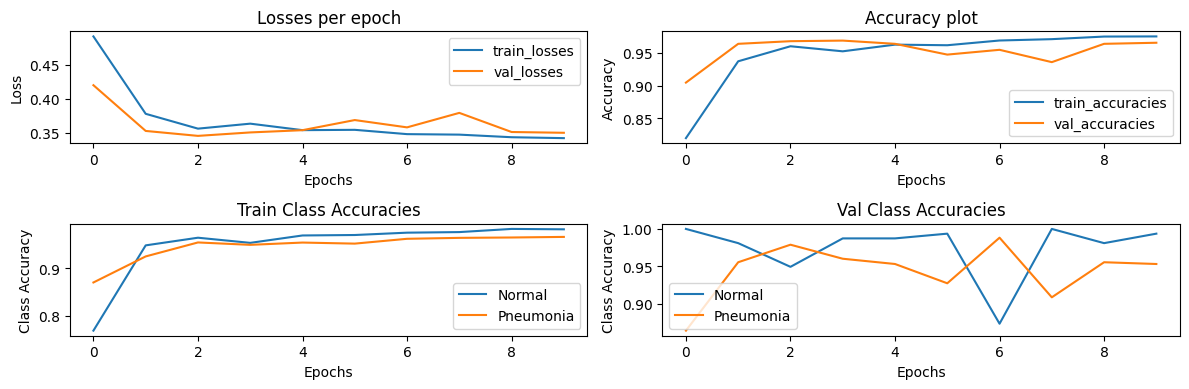

In [ ]:
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies,train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies)


In [ ]:
print("Train losses: ", train_losses)

print("Train accuracies: ", train_accuracies)
print("Train class accuracies: ", train_class_accuracies)
print("Val losses: ", val_losses)
print("Val accuracies: ", val_accuracies)
print("Val class accuracies: ", val_class_accuracies)
print("Train class Normal accuracies: ", train_class_0_accuracies)
print("Train class Pneumonia accuracies: ", train_class_1_accuracies)
print("Val class Normal accuracies: ", val_class_0_accuracies)
print("Val class Pneumonia accuracies: ", val_class_1_accuracies)

Train losses:  [0.4916374912472809, 0.3780054377049816, 0.35623249249393435, 0.3635473585858637, 0.35401508759479133, 0.35449444010955133, 0.348174835346183, 0.34744071717164954, 0.34363102406060614, 0.34229178148872996]
Train accuracies:  [0.8197987528344671, 0.9371456916099773, 0.9601048752834467, 0.9523809523809523, 0.9625850340136054, 0.9616638321995465, 0.9688917233560091, 0.9709467120181405, 0.9749149659863946, 0.9751275510204082]
Train class accuracies:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Val losses:  [0.4200151170554914, 0.3528635062669453, 0.34561063113965484, 0.3506668868817781, 0.3539667255000064, 0.3688344343712455, 0.35810443288401556, 0.37937558481567785, 0.351293179549669, 0.35014393141395167]
Val accuracies:  [0.9046052631578947, 0.9638157894736842, 0.9678362573099415, 0.96875, 0.9638157894736842, 0.9473684210526315, 0.9546783625730995, 0.9358552631578947, 0.9638157894736842, 0.9654605263157895]
Val class accuracies:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
#A bit clumsy - but added after the store the results above in separate lists for easy plotting
im_train_losses = [0.4916374912472809, 0.3780054377049816, 0.35623249249393435, 0.3635473585858637, 0.35401508759479133, 0.35449444010955133, 0.348174835346183, 0.34744071717164954, 0.34363102406060614, 0.34229178148872996]
im_train_acc =   [0.8197987528344671, 0.9371456916099773, 0.9601048752834467, 0.9523809523809523, 0.9625850340136054, 0.9616638321995465, 0.9688917233560091, 0.9709467120181405, 0.9749149659863946, 0.9751275510204082]
im_val_losses =  [0.4200151170554914, 0.3528635062669453, 0.34561063113965484, 0.3506668868817781, 0.3539667255000064, 0.3688344343712455, 0.35810443288401556, 0.37937558481567785, 0.351293179549669, 0.35014393141395167]
im_val_acc =  [0.9046052631578947, 0.9638157894736842, 0.9678362573099415, 0.96875, 0.9638157894736842, 0.9473684210526315, 0.9546783625730995, 0.9358552631578947, 0.9638157894736842, 0.9654605263157895]
im_train_normal_acc = [0.768277041470714, 0.9489927132447492, 0.9652137468566638, 0.9542906425183268, 0.9699828473413379, 0.9709373720835038, 0.9758985200845666, 0.9771309771309772, 0.9838504037399065, 0.9830220713073005]
im_train_p_acc =  [0.870362473347548, 0.9255635899617184, 0.9551784160139252, 0.9501057082452431, 0.9549319727891157, 0.9526996876394467, 0.9629150495903407, 0.9648968845985081, 0.9656799656799657, 0.9669243986254296]
im_val_normal_acc = [1.0, 0.9810126582278481, 0.9493670886075949, 0.9873417721518988, 0.9873417721518988, 0.9936708860759493, 0.8734177215189873, 1.0, 0.9810126582278481, 0.9936708860759493]
im_val_p_acc =  [0.8641686182669789, 0.955503512880562, 0.9789227166276346, 0.9601873536299765, 0.9531615925058547, 0.927400468384075, 0.9882903981264637, 0.9086651053864169, 0.955503512880562, 0.9531615925058547]

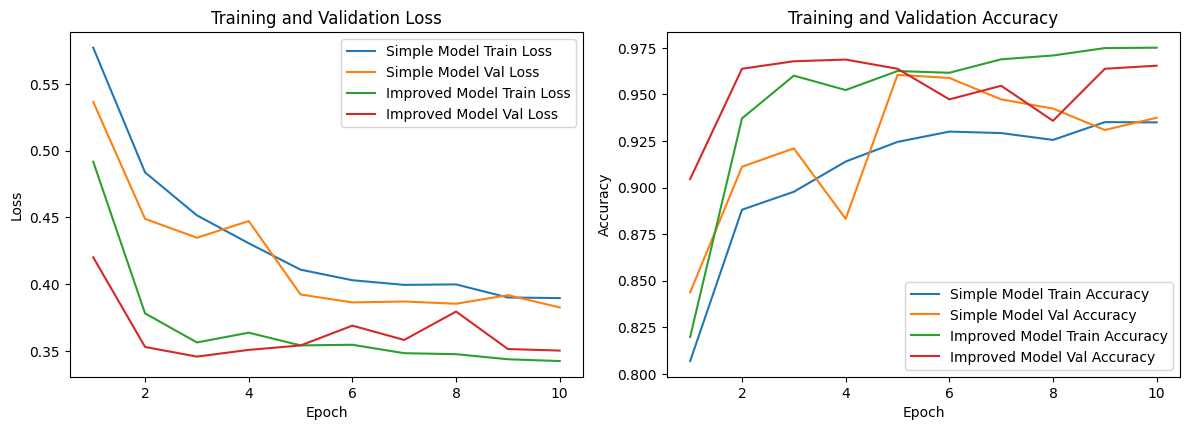

In [ ]:
# need a new function to compare simple model to improved model
# the function below will take in info about models and plot curves
def plot_curves(models):

    epochs = range(1, len(models[0][1]) + 1) #automatically get number of epochs in case it changes later
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)

    #below plots the loss per epoch
    for name, train_loss, _, val_loss, _ in models:
        plt.plot(epochs, train_loss, label=f'{name} Train Loss')
        plt.plot(epochs, val_loss, label=f'{name} Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    #below plots the accuracy per epoch

    plt.subplot(2, 2, 2)
    for name, _, train_acc, _, val_acc in models:
        plt.plot(epochs, train_acc, label=f'{name} Train Accuracy')
        plt.plot(epochs, val_acc, label=f'{name} Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Plot the curves
models = [('Simple Model', sm_train_losses, sm_train_acc, sm_val_losses, sm_val_acc),
          ('Improved Model', im_train_losses, im_train_acc, im_val_losses, im_val_acc)]
plot_curves(models)




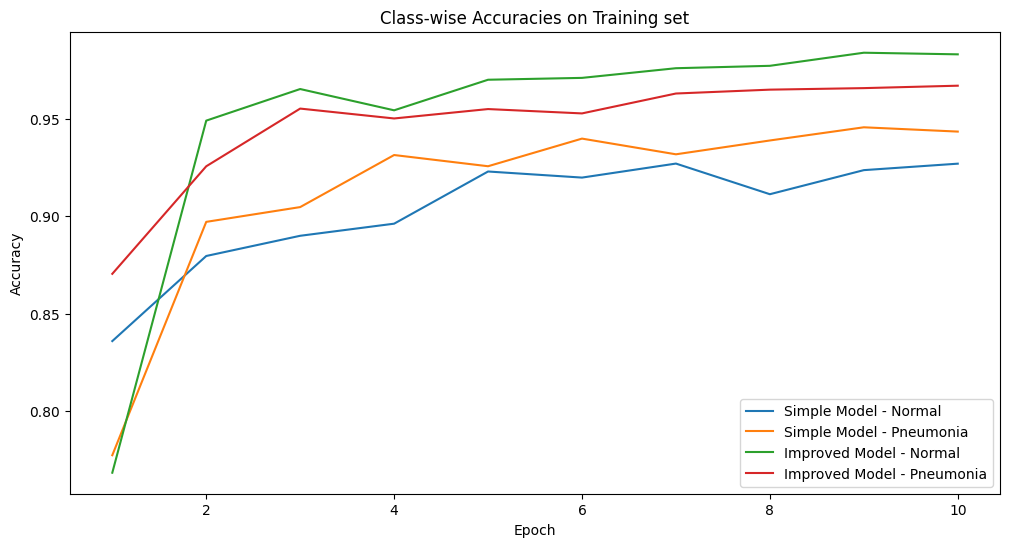

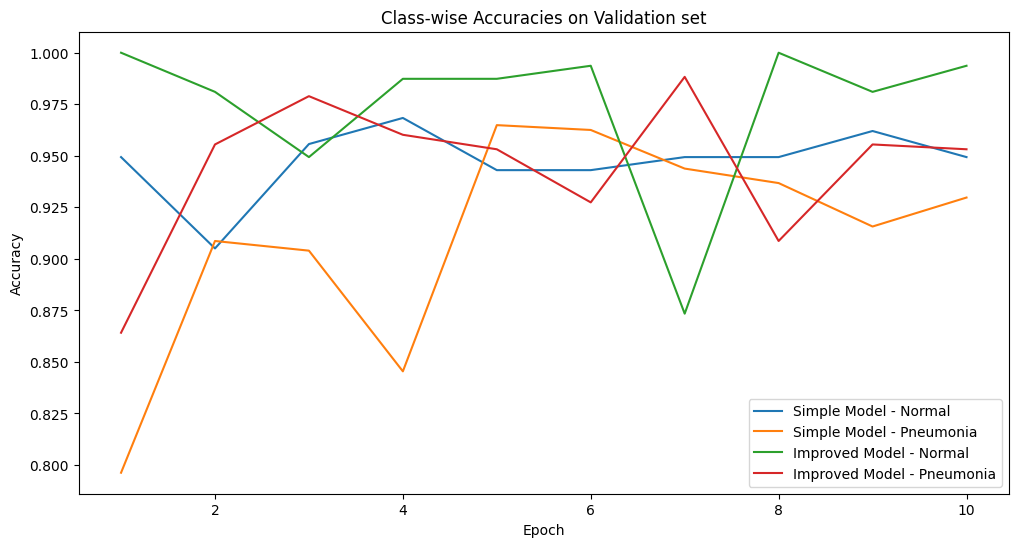

In [ ]:
# Need new function to plot class-wise accuracy

def plot_class_accuracies(models, class_labels, title):


    epochs = range(1, len(models[0][1]) + 1) #automatically get number of epochs

    plt.figure(figsize=(12, 6))

#make 2 loops because need to loop through simple/improved model and then classes
    for model_name, *accuracies in models:
        for i, class_label in enumerate(class_labels):
            plt.plot(epochs, accuracies[i], label=f"{model_name} - {class_label}")

    plt.title(f'Class-wise Accuracies on {title} set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



# Plot class-wise accauracies on training and validation set separately

models = [
    ('Simple Model', sm_train_normal_acc, sm_train_p_acc),
    ('Improved Model', im_train_normal_acc, im_train_p_acc)
]
class_labels = ['Normal', 'Pneumonia']
plot_class_accuracies(models, class_labels, "Training")

models = [
    ('Simple Model', sm_val_normal_acc, sm_val_p_acc),
    ('Improved Model', im_val_normal_acc, im_val_p_acc)
]
plot_class_accuracies(models, class_labels, "Validation")







**(a)**

*Insert a brief explanation of the three improvements you have used*

*For each improvment:*
1. *State the change being made;*
2. *State **why** this change could, in theory, improve the performance of the baseline model. If possible, motivate your hypothesis using empirical evidence from the baseline models results*


## Improvement 1: Wider CNN model##

1) The first improvement is to make the model more complex by adding more filters in the output layers (16 in the first output layer and 32 in the second output layer, as opposed to 8 and 16 in the baseline model).

2) In theory, this makes the model more complex. More filters may be able to help the model learn better by capturing more features in the input space and differentiating between features more - especially where intricate patterns in the images need to be learned. In theory, this could lead to higher accuracy. A caveat of using a wider CNN is the increased computational cost and risk of overfitting.

From baseline model results, we saw that overfitting did not occur, hence experimenting with a more complex model could optimize learning and lead to better results. From the baseline, it is difficult to say whether convergence took place as the losses formed a plateau in the final few epochs of training, however experimenting with a more complex structure could help the model learn patterns it was not previously able to detect.


## Improvement 2: Batch Normalization##

1) Batch normalization was introduced by normalizing inputs to each layer of the CNN.

2) In theory, batch normalization is a technique used to normalize inputs in each layer of the neural network. This can help improve the training process and lead to improved performance. Batch normalization is a popular technique. From the baseline model, there was no output that directly suggested to use batch normalization, however it is a generally used technique to create better models.


## Improvement 3: L2 regularization ##

1) L2 Regularization was implemented using a weight-decay parameter in the optimizer

2) In theory, this helps prevent overfitting and leads to improved generalization. It does this by favouring models that have smaller weights. In theory this should ideally lead to a slightly worse performance on the training set (and cause higher losses), as it prevents overfitting, however it should lead to better performance on the validation set - due to the model being able to generalize better. L2 regularization using weight decay was implemented to balance out "Improvement 1" which uses a more complex CNN model. Improvement 1 increases the risk of overfitting so L2 regularization helps to balance this out by reducing the risk of overfitting. In the baseline model, we saw that overfitting did not occur, however the losses began to plateau.


## Note on Other Potential Improvements ##
There are other improvements that could have been made to the baseline model.

Epochs: I had considered increasing the number of epochs, however the baseline model seemed to converge within 10 epochs.

Dropout: could be used to improve generalization

Deeper network: Using a CNN with more layers could allow the model to capture more features in the data. It increases risk of overfitting. I chose, instead, to make the network wider.

Learning Rate: I could have experimented with different learning rates to see if it leads to improved results.



**(b)**

_Present your results, including plots etc, here_

(Hint: ensure you compare to the baseline)

## Losses and accuracies per epoch ##

Epoch 1/10: Train Loss: 0.4916, Train Acc: 0.8198, Val Loss: 0.4200, Val Acc: 0.9046

Epoch 2/10: Train Loss: 0.3780, Train Acc: 0.9371, Val Loss: 0.3529, Val Acc: 0.9638

Epoch 3/10: Train Loss: 0.3562, Train Acc: 0.9601, Val Loss: 0.3456, Val Acc: 0.9678

Epoch 4/10: Train Loss: 0.3635, Train Acc: 0.9524, Val Loss: 0.3507, Val Acc: 0.9688

Epoch 5/10: Train Loss: 0.3540, Train Acc: 0.9626, Val Loss: 0.3540, Val Acc: 0.9638

Epoch 6/10: Train Loss: 0.3545, Train Acc: 0.9617, Val Loss: 0.3688, Val Acc: 0.9474

Epoch 7/10: Train Loss: 0.3482, Train Acc: 0.9689, Val Loss: 0.3581, Val Acc: 0.9547

Epoch 8/10: Train Loss: 0.3474, Train Acc: 0.9709, Val Loss: 0.3794, Val Acc: 0.9359

Epoch 9/10: Train Loss: 0.3436, Train Acc: 0.9749, Val Loss: 0.3513, Val Acc: 0.9638

Epoch 10/10: Train Loss: 0.3423, Train Acc: 0.9751, Val Loss: 0.3501, Val Acc: 0.9655


## Plots of Losses and Accuracies per Epoch ##

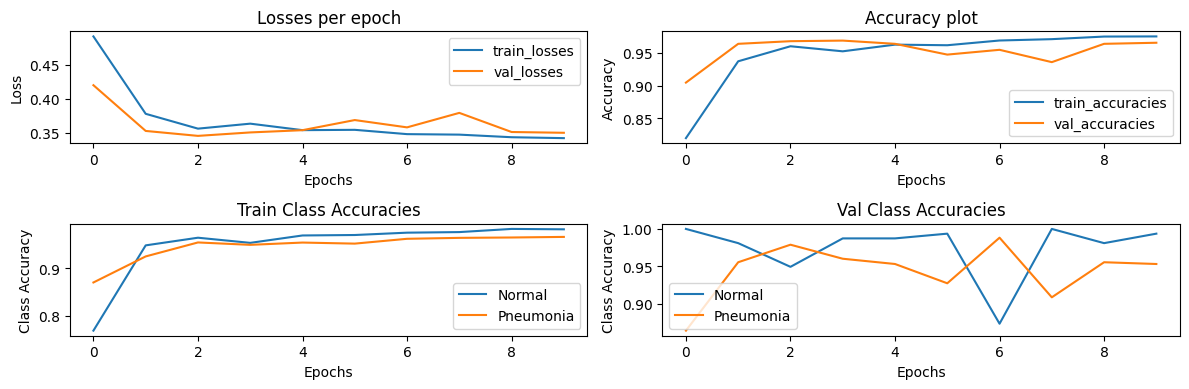

## Numerical Results ##

Train losses:  [0.4916374912472809, 0.3780054377049816, 0.35623249249393435, 0.3635473585858637, 0.35401508759479133, 0.35449444010955133, 0.348174835346183, 0.34744071717164954, 0.34363102406060614, 0.34229178148872996]

Train accuracies:  [0.8197987528344671, 0.9371456916099773, 0.9601048752834467, 0.9523809523809523, 0.9625850340136054, 0.9616638321995465, 0.9688917233560091, 0.9709467120181405, 0.9749149659863946, 0.9751275510204082]

Val losses:  [0.4200151170554914, 0.3528635062669453, 0.34561063113965484, 0.3506668868817781, 0.3539667255000064, 0.3688344343712455, 0.35810443288401556, 0.37937558481567785, 0.351293179549669, 0.35014393141395167]

Val accuracies:  [0.9046052631578947, 0.9638157894736842, 0.9678362573099415, 0.96875, 0.9638157894736842, 0.9473684210526315, 0.9546783625730995, 0.9358552631578947, 0.9638157894736842, 0.9654605263157895]

Train class Normal accuracies:  [0.768277041470714, 0.9489927132447492, 0.9652137468566638, 0.9542906425183268, 0.9699828473413379, 0.9709373720835038, 0.9758985200845666, 0.9771309771309772, 0.9838504037399065, 0.9830220713073005]

Train class Pneumonia accuracies:  [0.870362473347548, 0.9255635899617184, 0.9551784160139252, 0.9501057082452431, 0.9549319727891157, 0.9526996876394467, 0.9629150495903407, 0.9648968845985081, 0.9656799656799657, 0.9669243986254296]

Val class Normal accuracies:  [1.0, 0.9810126582278481, 0.9493670886075949, 0.9873417721518988, 0.9873417721518988, 0.9936708860759493, 0.8734177215189873, 1.0, 0.9810126582278481, 0.9936708860759493]

Val class Pneumonia accuracies:  [0.8641686182669789, 0.955503512880562, 0.9789227166276346, 0.9601873536299765, 0.9531615925058547, 0.927400468384075, 0.9882903981264637, 0.9086651053864169, 0.955503512880562, 0.9531615925058547]






## Comparison of Simple Model and Improved Model ##

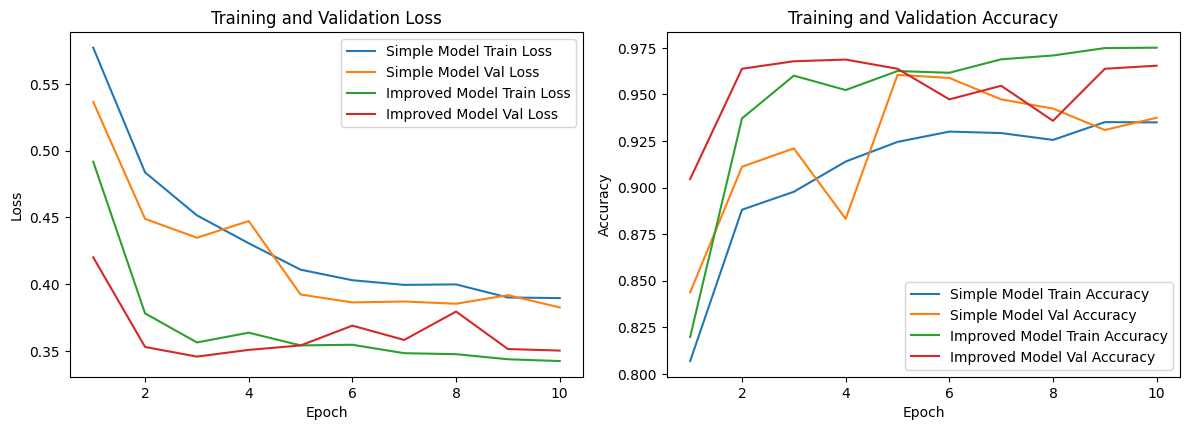

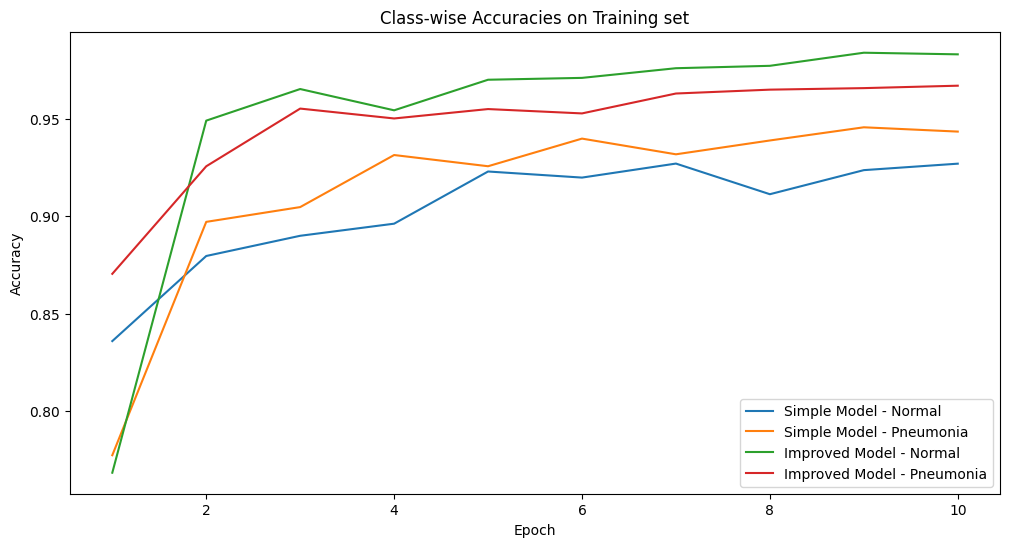

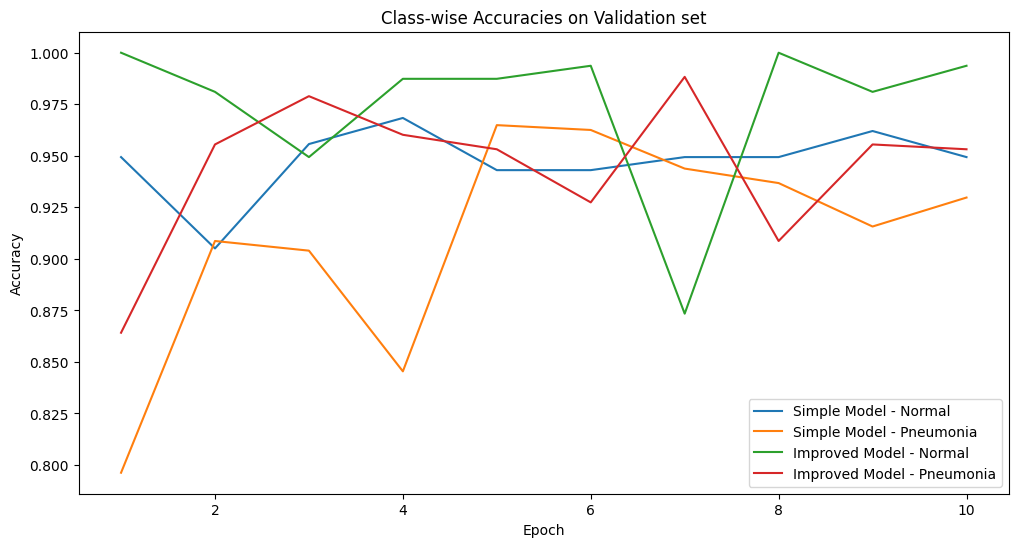

**(c)**

_Discuss your results here_

## Overall Result##

The improved model performed better than the baseline model - having lower losses and higher accuracies on both the training and validation set.

## Plots of Losses and Accuracies per Epoch ##

The "Losses per epoch" graph above shows that training loss and validation loss plateau - indicating the model has found a minima (this could be a local minimum or a global minimum). It could indicate that the model is struggling to improve further as it has found an optimal solution.

The Accuracy Plot above also indicates good model performance. The model achieved accuracy of 97.5% on training set and 96.6% on the validation set.

An interesting result from the class-wise accuracy plot on the validation set is that there seems to be a negative correlation between accuracy on Normal images and accuracy on Pneumonia images. This is likely due to the fact that, as the model learns, it develops slight biases to one class over another.

## Evidence that the Model is a Good Fit ##

We do not see a divergence between validation loss and training loss, hence overfitting has not occurred.

Furthermore, the model achieves high accuracy, hence it is difficult to argue that the model underfits. In addition, validation loss reaches a plateau (and is not steadily decreases) which indicates that underfitting has not occurred.

Since overfitting and underfitting have not occurred, we can conclude that the model is a good fit.

##Comparison of Simple Model and Improved Model##

The improved model achieves lower losses and higher accuracies than the simple model. The shapes of the respective loss functions are quite similar, although the improved model has lower losses - indcating that its more complex architecture allows it to capture significant features in the data that the simple model may have missed.

On the validation set, both models have higher accuracy on Normal images than Pneumonia images.



## Q 4.2: Empirically justify improvement 1 (10 marks)

Now you will empirically demonstrate the contribution of each improvement to the final performance of your model.

To justify the utility of an improvement, you should present one of the following experiments:
- *Option 1:* Train the final model _without_ that improvement (but still with the other two improvements). Compare these results to the results you presented previously with all three improvements. If the improvement is useful, removing it should result in a drop in performance
- *Option 2:* Compare the performance of baseline to the perfroamnce of the baseline plus a single improvement. If the improvement is useful, you should expect improved performance versus the baseline.

You will still get a significant portion of the marks if the proposed improvement was well-motivated but does not empirically improve perfromance. In this case, ensure your discussion touches on why performance may not have improved or any other interesting talking points.


In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# I will be doing Option 2 (Baseline + single improvement)

# Improvement 1: Wider network by more filters


class layers_Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) #8 in output layer changed to 16
    self.relu1 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) #16 in output layer changed to 32
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.flatten = nn.Flatten()

    self.fc = nn.Linear(32 * 56 * 56, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu2(x)
    x = self.pool2(x)

    x = self.flatten(x)
    x = self.fc(x)

    x = torch.softmax(x, dim=1) #so outputs can be interpreted as probabilities

    return x


layers_model = layers_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(layers_model.parameters(), lr= lr)


train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies  = train_model(
    layers_model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10: Train Loss: 0.5677, Train Acc: 0.8114, Val Loss: 0.4691, Val Acc: 0.9218
Epoch 2/10: Train Loss: 0.4642, Train Acc: 0.9064, Val Loss: 0.4168, Val Acc: 0.9465
Epoch 3/10: Train Loss: 0.4294, Train Acc: 0.9152, Val Loss: 0.3976, Val Acc: 0.9556
Epoch 4/10: Train Loss: 0.4159, Train Acc: 0.9197, Val Loss: 0.3978, Val Acc: 0.9441
Epoch 5/10: Train Loss: 0.4034, Train Acc: 0.9345, Val Loss: 0.3859, Val Acc: 0.9507
Epoch 6/10: Train Loss: 0.3991, Train Acc: 0.9286, Val Loss: 0.3787, Val Acc: 0.9539
Epoch 7/10: Train Loss: 0.3921, Train Acc: 0.9358, Val Loss: 0.3888, Val Acc: 0.9342
Epoch 8/10: Train Loss: 0.3946, Train Acc: 0.9278, Val Loss: 0.3694, Val Acc: 0.9655
Epoch 9/10: Train Loss: 0.3920, Train Acc: 0.9306, Val Loss: 0.3756, Val Acc: 0.9539
Epoch 10/10: Train Loss: 0.3866, Train Acc: 0.9327, Val Loss: 0.3755, Val Acc: 0.9474


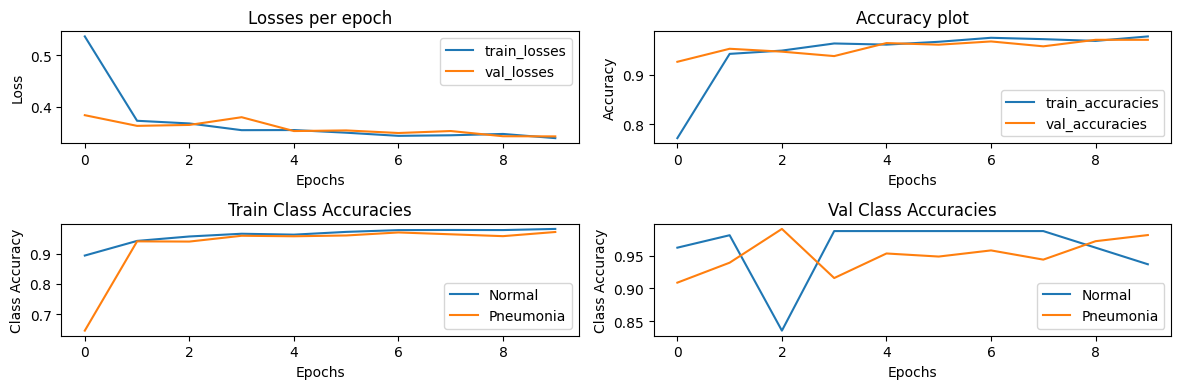

In [ ]:
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies,train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies)


**(a)**

_State the improvement you are justifying_

##Using a wider CNN##
The first improvement is to make the model more complex by adding more filters in the output layers (16 in the first output layer and 32 in the second output layer, as opposed to 8 and 16 in the baseline model).

**(b)**

_Present your results, including plots etc, here_

## Losses and Accuracy per Epoch ##
Epoch 1/10: Train Loss: 0.5677, Train Acc: 0.8114, Val Loss: 0.4691, Val Acc: 0.9218

Epoch 2/10: Train Loss: 0.4642, Train Acc: 0.9064, Val Loss: 0.4168, Val Acc: 0.9465

Epoch 3/10: Train Loss: 0.4294, Train Acc: 0.9152, Val Loss: 0.3976, Val Acc: 0.9556

Epoch 4/10: Train Loss: 0.4159, Train Acc: 0.9197, Val Loss: 0.3978, Val Acc: 0.9441

Epoch 5/10: Train Loss: 0.4034, Train Acc: 0.9345, Val Loss: 0.3859, Val Acc: 0.9507

Epoch 6/10: Train Loss: 0.3991, Train Acc: 0.9286, Val Loss: 0.3787, Val Acc: 0.9539

Epoch 7/10: Train Loss: 0.3921, Train Acc: 0.9358, Val Loss: 0.3888, Val Acc: 0.9342

Epoch 8/10: Train Loss: 0.3946, Train Acc: 0.9278, Val Loss: 0.3694, Val Acc: 0.9655

Epoch 9/10: Train Loss: 0.3920, Train Acc: 0.9306, Val Loss: 0.3756, Val Acc: 0.9539

Epoch 10/10: Train Loss: 0.3866, Train Acc: 0.9327, Val Loss: 0.3755, Val Acc: 0.9474

## Plots of Losses and Accuracy##
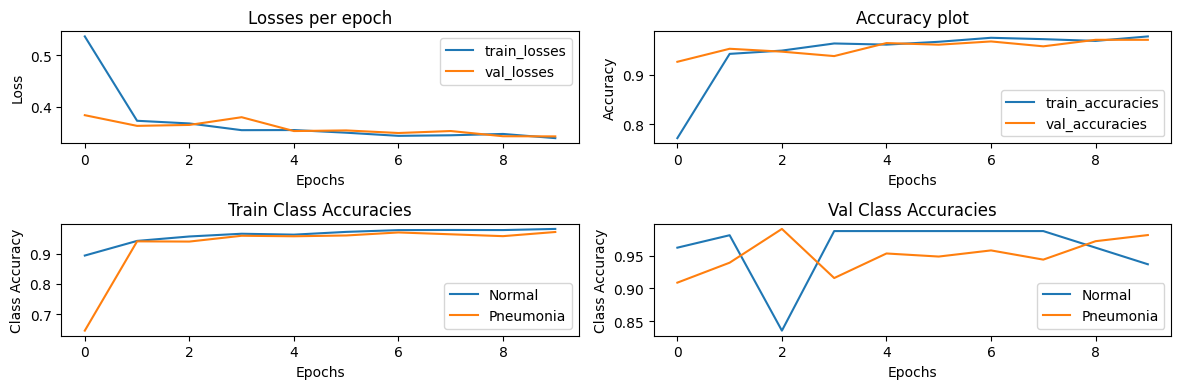

## Reminder: Simple Model Results ##
Epoch 1/10: Train Loss: 0.5770, Train Acc: 0.8068, Val Loss: 0.5364, Val Acc: 0.8438

Epoch 2/10: Train Loss: 0.4836, Train Acc: 0.8881, Val Loss: 0.4488, Val Acc: 0.9112

Epoch 3/10: Train Loss: 0.4514, Train Acc: 0.8977, Val Loss: 0.4347, Val Acc: 0.9211

Epoch 4/10: Train Loss: 0.4305, Train Acc: 0.9140, Val Loss: 0.4472, Val Acc: 0.8832

Epoch 5/10: Train Loss: 0.4108, Train Acc: 0.9245, Val Loss: 0.3921, Val Acc: 0.9605

Epoch 6/10: Train Loss: 0.4028, Train Acc: 0.9301, Val Loss: 0.3862, Val Acc: 0.9589

Epoch 7/10: Train Loss: 0.3994, Train Acc: 0.9293, Val Loss: 0.3869, Val Acc: 0.9474

Epoch 8/10: Train Loss: 0.3997, Train Acc: 0.9256, Val Loss: 0.3852, Val Acc: 0.9424

Epoch 9/10: Train Loss: 0.3899, Train Acc: 0.9352, Val Loss: 0.3917, Val Acc: 0.9309

Epoch 10/10: Train Loss: 0.3895, Train Acc: 0.9350, Val Loss: 0.3825, Val Acc: 0.9375

**(c)**

_Discuss your results here_

Overall, using a wider network improved model performance

Using a wider CNN causes better accuracy on the validation set and lower loss on the validation set. This was expected as a network with more filters would, in theory, be able to capture more salient features of the data. Interestingly, losses and accuracies on the training data were quite similar to the simple model. This could suggest the complex models has reduced overfitting.

There is no divergence between validation loss and training loss, hence overfitting does not occur. The validation loss also begins to plateau.

Validation accuracy on the Normal class was very high up until the last few epochs of training, where the negative correlation between Normal accuracy and Pneumonia accuracy is seen - Pneumonia accuracy improves while Normal accuracy decreases.

It is important to note that the simple model achieved quite a high accuracy as a baseline, so it is reasonable to expect that improvement to the baseline model will result in marginal improvements in accuracy.


## Q 4.3: Empirically justify improvement 2 (10 marks)

In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Improvement 2: Batch normalization

class batch_Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1) #same layers as SimpleModel()
    self.bn1 = nn.BatchNorm2d(8) #Batch normalization
    self.relu1 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(16) #Batch normalization
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2, 2)

    self.flatten = nn.Flatten()

    self.fc = nn.Linear(16 * 56 * 56, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.pool2(x)

    x = self.flatten(x)
    x = self.fc(x)

    x = torch.softmax(x, dim=1) #so outputs can be interpreted as probabilities

    return x


batch_model = batch_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(batch_model.parameters(), lr= lr)

train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies  = train_model(
    batch_model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)


Epoch 1/10: Train Loss: 0.4253, Train Acc: 0.8933, Val Loss: 0.3661, Val Acc: 0.9613
Epoch 2/10: Train Loss: 0.3743, Train Acc: 0.9471, Val Loss: 0.3605, Val Acc: 0.9605
Epoch 3/10: Train Loss: 0.3630, Train Acc: 0.9579, Val Loss: 0.3856, Val Acc: 0.9408
Epoch 4/10: Train Loss: 0.3620, Train Acc: 0.9564, Val Loss: 0.3504, Val Acc: 0.9645
Epoch 5/10: Train Loss: 0.3547, Train Acc: 0.9651, Val Loss: 0.3604, Val Acc: 0.9539
Epoch 6/10: Train Loss: 0.3552, Train Acc: 0.9646, Val Loss: 0.3472, Val Acc: 0.9678
Epoch 7/10: Train Loss: 0.3512, Train Acc: 0.9699, Val Loss: 0.3825, Val Acc: 0.9309
Epoch 8/10: Train Loss: 0.3488, Train Acc: 0.9713, Val Loss: 0.3480, Val Acc: 0.9655
Epoch 9/10: Train Loss: 0.3511, Train Acc: 0.9666, Val Loss: 0.3505, Val Acc: 0.9638
Epoch 10/10: Train Loss: 0.3456, Train Acc: 0.9745, Val Loss: 0.3497, Val Acc: 0.9638


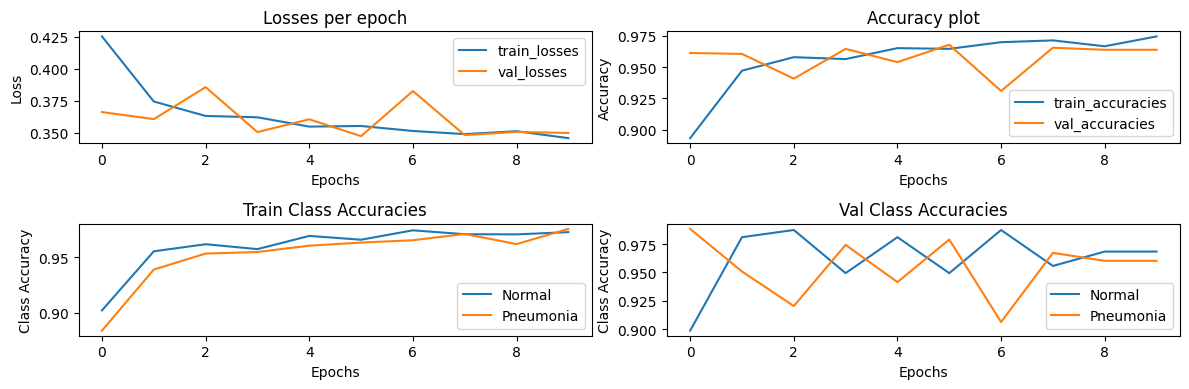

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies,train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies)

plt.suptitle("Improvement 2: Training and Validation Curves")
plt.show()

**(a)**

_State the improvement you are justifying_

## Batch Normalization##

Batch normalization was introduced by normalizing inputs to each layer of the CNN.

**(b)**

_Present your results, including plots etc, here_

Epoch 1/10: Train Loss: 0.4253, Train Acc: 0.8933, Val Loss: 0.3661, Val Acc: 0.9613

Epoch 2/10: Train Loss: 0.3743, Train Acc: 0.9471, Val Loss: 0.3605, Val Acc: 0.9605

Epoch 3/10: Train Loss: 0.3630, Train Acc: 0.9579, Val Loss: 0.3856, Val Acc: 0.9408

Epoch 4/10: Train Loss: 0.3620, Train Acc: 0.9564, Val Loss: 0.3504, Val Acc: 0.9645

Epoch 5/10: Train Loss: 0.3547, Train Acc: 0.9651, Val Loss: 0.3604, Val Acc: 0.9539

Epoch 6/10: Train Loss: 0.3552, Train Acc: 0.9646, Val Loss: 0.3472, Val Acc: 0.9678

Epoch 7/10: Train Loss: 0.3512, Train Acc: 0.9699, Val Loss: 0.3825, Val Acc: 0.9309

Epoch 8/10: Train Loss: 0.3488, Train Acc: 0.9713, Val Loss: 0.3480, Val Acc: 0.9655

Epoch 9/10: Train Loss: 0.3511, Train Acc: 0.9666, Val Loss: 0.3505, Val Acc: 0.9638

Epoch 10/10: Train Loss: 0.3456, Train Acc: 0.9745, Val Loss: 0.3497, Val Acc: 0.9638



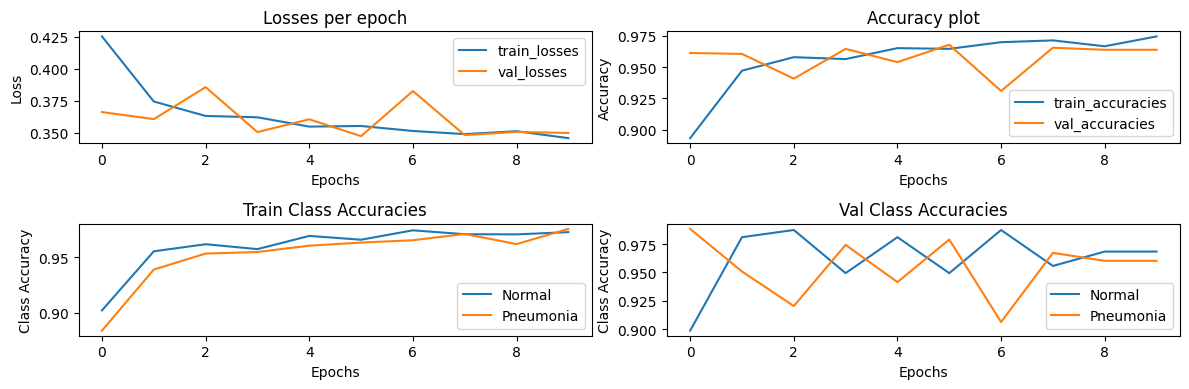



## Reference: Simple Model result##

Epoch 1/10: Train Loss: 0.5770, Train Acc: 0.8068, Val Loss: 0.5364, Val Acc: 0.8438

Epoch 2/10: Train Loss: 0.4836, Train Acc: 0.8881, Val Loss: 0.4488, Val Acc: 0.9112

Epoch 3/10: Train Loss: 0.4514, Train Acc: 0.8977, Val Loss: 0.4347, Val Acc: 0.9211

Epoch 4/10: Train Loss: 0.4305, Train Acc: 0.9140, Val Loss: 0.4472, Val Acc: 0.8832

Epoch 5/10: Train Loss: 0.4108, Train Acc: 0.9245, Val Loss: 0.3921, Val Acc: 0.9605

Epoch 6/10: Train Loss: 0.4028, Train Acc: 0.9301, Val Loss: 0.3862, Val Acc: 0.9589

Epoch 7/10: Train Loss: 0.3994, Train Acc: 0.9293, Val Loss: 0.3869, Val Acc: 0.9474

Epoch 8/10: Train Loss: 0.3997, Train Acc: 0.9256, Val Loss: 0.3852, Val Acc: 0.9424

Epoch 9/10: Train Loss: 0.3899, Train Acc: 0.9352, Val Loss: 0.3917, Val Acc: 0.9309

Epoch 10/10: Train Loss: 0.3895, Train Acc: 0.9350, Val Loss: 0.3825, Val Acc: 0.9375


**(c)**

_Discuss your results here_

As expected, batch normalization significantly improves model performance. It leads to lower losses and higher accuracies on both training and validation.

There was a strange spike at epoch 6 in the validation loss, however it decreased at the next epoch.

Interestingly, this improvement performs slightly better on the Normal class (for validation) than Pneumonia, whereas the previous improvement favoured the Pneumonia class.

## Q 4.4: Empirically justify improvement 3 (10 marks)

In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Improvement 3: L2 Regularization

criterion_more_layers = nn.CrossEntropyLoss()
optimizer_more_layers = torch.optim.SGD(model.parameters(), lr= lr, weight_decay= 0.001) #introduce weight decay parameter

train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies= train_model(
    model, train_loader, val_loader, criterion_more_layers, optimizer_more_layers, num_epochs, device, use_wandb
)



Epoch 1/10: Train Loss: 0.3899, Train Acc: 0.9343, Val Loss: 0.3987, Val Acc: 0.9243
Epoch 2/10: Train Loss: 0.3884, Train Acc: 0.9333, Val Loss: 0.3824, Val Acc: 0.9359
Epoch 3/10: Train Loss: 0.3832, Train Acc: 0.9396, Val Loss: 0.3692, Val Acc: 0.9589
Epoch 4/10: Train Loss: 0.3824, Train Acc: 0.9382, Val Loss: 0.3799, Val Acc: 0.9326
Epoch 5/10: Train Loss: 0.3861, Train Acc: 0.9338, Val Loss: 0.3812, Val Acc: 0.9375
Epoch 6/10: Train Loss: 0.3870, Train Acc: 0.9311, Val Loss: 0.3863, Val Acc: 0.9293
Epoch 7/10: Train Loss: 0.3770, Train Acc: 0.9418, Val Loss: 0.3858, Val Acc: 0.9326
Epoch 8/10: Train Loss: 0.3737, Train Acc: 0.9463, Val Loss: 0.3669, Val Acc: 0.9539
Epoch 9/10: Train Loss: 0.3817, Train Acc: 0.9352, Val Loss: 0.3740, Val Acc: 0.9424
Epoch 10/10: Train Loss: 0.3747, Train Acc: 0.9429, Val Loss: 0.3709, Val Acc: 0.9441


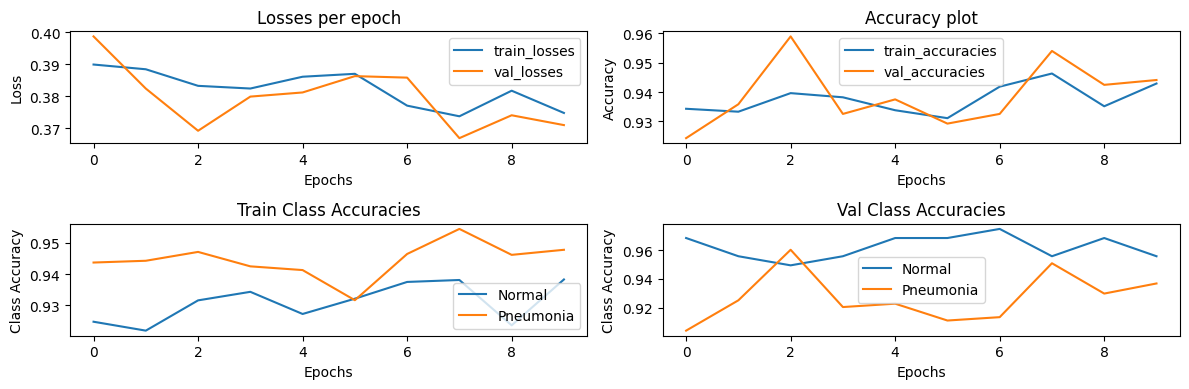

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies,train_class_0_accuracies, train_class_1_accuracies, val_class_0_accuracies, val_class_1_accuracies)

plt.suptitle("Improvement 3: Training and Validation Curves")
plt.show()

**(a)**

_State the improvement you are justifying_

##Weight decay (L2 Regularization)##
L2 Regularization was implemented using a weight-decay parameter in the optimizer

**(b)**

_Present your results, including plots etc, here_

Epoch 1/10: Train Loss: 0.3899, Train Acc: 0.9343, Val Loss: 0.3987, Val Acc: 0.9243

Epoch 2/10: Train Loss: 0.3884, Train Acc: 0.9333, Val Loss: 0.3824, Val Acc: 0.9359

Epoch 3/10: Train Loss: 0.3832, Train Acc: 0.9396, Val Loss: 0.3692, Val Acc: 0.9589

Epoch 4/10: Train Loss: 0.3824, Train Acc: 0.9382, Val Loss: 0.3799, Val Acc: 0.9326

Epoch 5/10: Train Loss: 0.3861, Train Acc: 0.9338, Val Loss: 0.3812, Val Acc: 0.9375

Epoch 6/10: Train Loss: 0.3870, Train Acc: 0.9311, Val Loss: 0.3863, Val Acc: 0.9293

Epoch 7/10: Train Loss: 0.3770, Train Acc: 0.9418, Val Loss: 0.3858, Val Acc: 0.9326

Epoch 8/10: Train Loss: 0.3737, Train Acc: 0.9463, Val Loss: 0.3669, Val Acc: 0.9539

Epoch 9/10: Train Loss: 0.3817, Train Acc: 0.9352, Val Loss: 0.3740, Val Acc: 0.9424

Epoch 10/10: Train Loss: 0.3747, Train Acc: 0.9429, Val Loss: 0.3709, Val Acc: 0.9441


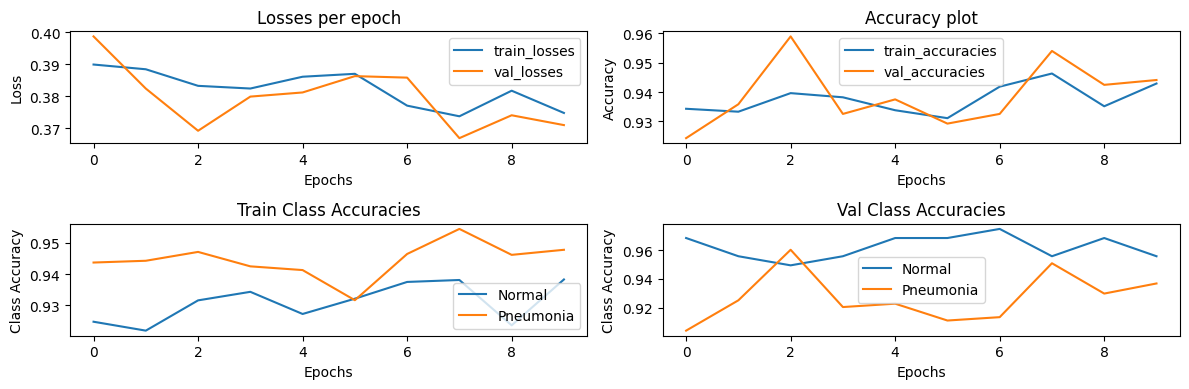

## Reference: Simple Model result##

Epoch 1/10: Train Loss: 0.5770, Train Acc: 0.8068, Val Loss: 0.5364, Val Acc: 0.8438

Epoch 2/10: Train Loss: 0.4836, Train Acc: 0.8881, Val Loss: 0.4488, Val Acc: 0.9112

Epoch 3/10: Train Loss: 0.4514, Train Acc: 0.8977, Val Loss: 0.4347, Val Acc: 0.9211

Epoch 4/10: Train Loss: 0.4305, Train Acc: 0.9140, Val Loss: 0.4472, Val Acc: 0.8832

Epoch 5/10: Train Loss: 0.4108, Train Acc: 0.9245, Val Loss: 0.3921, Val Acc: 0.9605

Epoch 6/10: Train Loss: 0.4028, Train Acc: 0.9301, Val Loss: 0.3862, Val Acc: 0.9589

Epoch 7/10: Train Loss: 0.3994, Train Acc: 0.9293, Val Loss: 0.3869, Val Acc: 0.9474

Epoch 8/10: Train Loss: 0.3997, Train Acc: 0.9256, Val Loss: 0.3852, Val Acc: 0.9424

Epoch 9/10: Train Loss: 0.3899, Train Acc: 0.9352, Val Loss: 0.3917, Val Acc: 0.9309

Epoch 10/10: Train Loss: 0.3895, Train Acc: 0.9350, Val Loss: 0.3825, Val Acc: 0.9375

**(c)**

_Discuss your results here_

The model with weight decay had lower losses and better accuracy on both the training and validation set.

Better results on the validation set was expected, since the weight decay generally improves the generalization capacity of the model.

However, better performance on the training set was unexpected. Weight decay favours generalization, as opposed to overfitting. In theory, this should lead to worse performance on the training set.


Overall this improvement (as well as the other 2 improvements) leads to better model performance.

# Question 5: Final Evaluation (10 marks)

You should perform a final evaluation of the performance of your model


In [ ]:
# Implement evaluation here

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

#the function below evaulates the model on the test data
def evaluate_model(model, dataloader, criterion, device='cuda'):

  # similar steps to performaing validation on a model
  model.eval()

  test_loss = 0.0
  correct = 0
  num_samples = 0

  #lists to keep track of predicted vs actual
  pred_list = []
  target_list = []


  with torch.no_grad():
    for data, target in dataloader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target)
      pred = output.argmax(dim=1) #class with highest probability
      correct += (pred == target).type(torch.float).sum().item()
      num_samples += target.size(0)  # Track total number of samples
      pred_list.append(pred)  # Append predictions to the list
      target_list.append(target)  # Append actual labels to the list



  test_loss /= len(dataloader)
  test_acc = correct / num_samples

  return test_loss, test_acc, pred_list, target_list

# evaluate models on test set
test_loss1, test_acc1, pred_list1, target_list1 = evaluate_model(model, test_loader, criterion, device)
test_loss2, test_acc2, pred_list2, target_list2 = evaluate_model(model_improved, test_loader, criterion_improved, device)

print(f"Simple Model: Test Loss: {test_loss1:.4f}, Test Accuracy: {test_acc1:.4f}")
print(f"Improved Model: Test Loss: {test_loss2:.4f}, Test Accuracy: {test_acc2:.4f}")


# Steps below set up the data to plot a nice visual Confusion Matrix
# the confusion matrix will be executed in next cell
pred_list1 = [p.cpu().numpy() for p in pred_list1] # Move each tensor to CPU and convert
target_list1 = [t.cpu().numpy() for t in target_list1]

pred_list2 = [p.cpu().numpy() for p in pred_list2]
target_list2 = [t.cpu().numpy() for t in target_list2]

pred_list1 = np.concatenate(pred_list1)
target_list1 = np.concatenate(target_list1)
pred_list2 = np.concatenate(pred_list2)
target_list2 = np.concatenate(target_list2)



Simple Model: Test Loss: 0.4085, Test Accuracy: 0.9182 
Improved Model: Test Loss: 0.3635, Test Accuracy: 0.9455


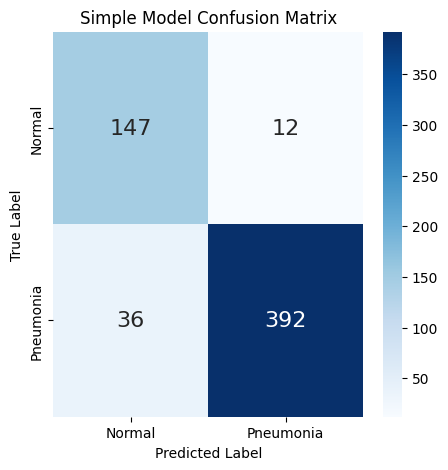

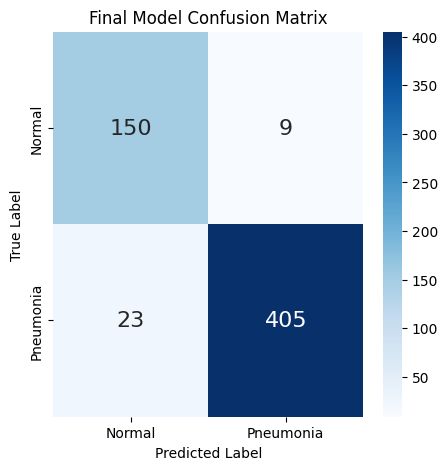

In [ ]:
# The code below helps plot Confusion Matrices
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# Confusion Matrix for Simple Model
confusion_matrix_simple = confusion_matrix(target_list1, pred_list1)
confusion_matrix_simple = pd.DataFrame(confusion_matrix_simple , index = ['Normal','Pneumonia'] , columns = ['Normal','Pneumonia'])
plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix_simple,cmap= "Blues", linecolor = 'black'  , annot = True, fmt='',annot_kws={"size": 16})
plt.title('Simple Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Confusion Matrix for Final Model
confusion_matrix_final = confusion_matrix(target_list2, pred_list2)
confusion_matrix_final = pd.DataFrame(confusion_matrix_final , index = ['Normal','Pneumonia'] , columns = ['Normal','Pneumonia'])
plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix_final,cmap= "Blues", linecolor = 'black'  , annot = True, fmt='',annot_kws={"size": 16})
plt.title('Final Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
#SIMPLE MODEL RESULTS
# confusion_matrix_simple["Pred"]["Actual"]
#Pneumonia will be treated as the "Positive" prediction to comply with medical terms
 #e.g., someone can test positive for pneumonia so false positive would be pneumonia is predicted when actually normal

tp_simple = confusion_matrix_simple["Pneumonia"]["Pneumonia"]
tn_simple = confusion_matrix_simple["Normal"]["Normal"]
fn_simple = confusion_matrix_simple["Normal"]["Pneumonia"]
fp_simple = confusion_matrix_simple["Pneumonia"]["Normal"]

precision_simple = tp_simple / (tp_simple + fp_simple)
recall_simple = tp_simple / (tp_simple + fn_simple)
specificity_simple = tn_simple / (tn_simple + fp_simple)
accuracy_simple = (tp_simple + tn_simple) / (tp_simple + tn_simple + fp_simple + fn_simple)

f1_simple = 2 * (precision_simple * recall_simple) / (precision_simple + recall_simple)

print("Accuracy:", round(accuracy_simple,3))
print("Specificity:", round(specificity_simple,3))
print("Precision:", round(precision_simple,3))
print("Recall:", round(recall_simple,3))
print("F1 Score:", round(f1_simple,3))

Accuracy: 0.918
Specificity: 0.925
Precision: 0.97
Recall: 0.916
F1 Score: 0.942


In [ ]:
#IMPROVED MODEL RESULTS
# confusion_matrix_simple["Pred"]["Actual"]

tp_improved = confusion_matrix_final["Pneumonia"]["Pneumonia"]
tn_improved= confusion_matrix_final["Normal"]["Normal"]
fn_improved= confusion_matrix_final["Normal"]["Pneumonia"]
fp_improved = confusion_matrix_final["Pneumonia"]["Normal"]

precision_improved = tp_improved / (tp_improved+ fp_improved)
recall_improved= tp_improved/ (tp_improved+ fn_improved)
specificity_improved= tn_improved / (tn_improved+ fp_improved)
accuracy_improved = (tp_improved + tn_improved) / (tp_improved+ tn_improved + fp_improved + fn_improved)

f1_improved = 2 * (precision_improved * recall_improved) / (precision_improved + recall_improved)

print("Accuracy:", round(accuracy_improved,3))
print("Specificity:", round(specificity_improved,3))
print("Precision:", round(precision_improved,3))
print("Recall:", round(recall_improved,3))
print("F1 Score:", round(f1_improved,3))

Accuracy: 0.945
Specificity: 0.943
Precision: 0.978
Recall: 0.946
F1 Score: 0.962


**(a)**

_Present your results, including plots etc, here_

## Results on Test Set ##

Simple Model: Test Loss: 0.4085, Test Accuracy: 0.9182

Improved Model: Test Loss: 0.3635, Test Accuracy: 0.9455


## Confusion Matrix for Simple Model and Improved Model ##

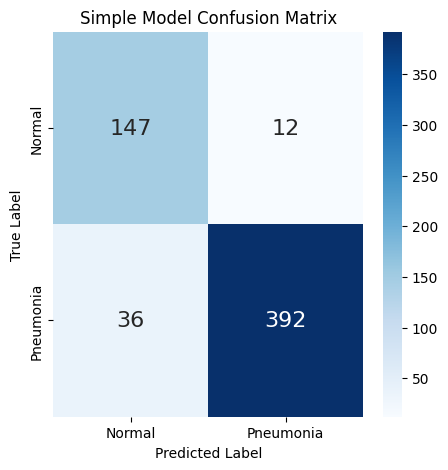

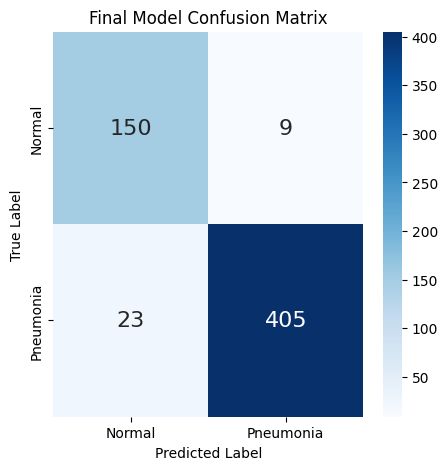


##SUMMARY RESULTS##

SIMPLE MODEL

Accuracy: 0.918

Specificity: 0.925

Precision: 0.97

Recall: 0.916

F1 Score: 0.942


IMPROVED MODEL

Accuracy: 0.945

Specificity: 0.943

Precision: 0.978

Recall: 0.946

F1 Score: 0.962

**(b)**

_Discuss your results here_

As expected, the final model has superior performance on the test set (with a lower loss and a higher accuracy).

Both models respectively performed worse on the validation set than the test set.

The Confusion Matrices confirm that the improved model performs better than the baseline model, for classifying both Normal and Pneumonia images.

In this case:

True positive = True Label: Pneumonia, Predicted Label: Pneumonia

False positive = True Label: Normal, Predicted Label: Pneumonia

True negative = True Label: Normal, Predicted Label: Normal

False negative = True Label: Pneumonia, Predicted Label: Normal


Both false positives and false negatives decreased in the improved model.


In an actual clinical setting, the 23 false negatives (where the patient actually has Pneumonia but the model predicts Normal) under the improved model can still be an area for concern. It might lead the doctors to misdiagnose someone as healthy when they actually have pneumonia.


## Summary Results ##

Accuracy is a measure of total predictions divided by total number of predictions. Accuracy was higher under the improved model.

Specificity: Proportion of true negatives that are identified: TN / (TN + FP). In this case, the numerator would be total Normal cases correctly predicted and the denominator would be total actual Normal cases. Specificity improved under the improved model.

Recall: Proportion of true positives that are identified: TP / (TP + FN). In this case, the numerator would be total Pneumonia cases correctly predicted and the denominator would be total actual Pneumonia cases. Recall improved under the improved model.

Precision: A measure of The proportion of positive predictions that were correctly identified: TP / (FP + TP). The numerator is Pneumonia cases correctly predicted. The denominator is total Pneumonia predictions. Accuracy improved slightly under the improved model.

The F1 score is used as a metric to compare accuracies of models. It was better under the improved model.

Hence, under all evaluation metrics, the improved model was better. The improved accuracy seems to be driven primarily by improved recall, however precision and specificity also increased under the improved model.






